# **Quality Data Analysis** - Course Project 2024

<img src="Figs/Logo.png" alt="Logo" width="800">

# Phase 1
---
## Introduction

This project is part of the **Quality Data Analysis** course at Politecnico di Milano, offered by the Department of Mechanical Engineering.

### Objective
The primary aim is to design and evaluate a statistical method for effectively identifying quality errors and anomalies in 3D-printed parts. The project focuses on detecting defects in Voronoi filters by analyzing images captured in real time during the simulation of the production process.

### Dataset Overview
To support this research, a dataset comprising **40 pieces** was collected using a specialized machine at the **MADE Competence Center I4.0 laboratory**. Each sample in the dataset includes:
- An image of the filter.
- A clearly visible part number tag for straightforward identification.

For **Phase 1**, only data without faulty parts was provided. This phase focuses on developing **Statistical Process Control (SPC)** techniques to ensure process stability and establish a baseline for quality analysis.


## Dataset Uploading and Transformation

We will:
1. Import necessary Python modules for data analysis.
2. Load the dataset for processing.

In [64]:
# import the useful general modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import qda

In [65]:
#We have imported the original dataset
csv_file_path = 'dataset_phase1/Result/image_statistics.csv'
df = pd.read_csv(csv_file_path)
df.head()

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
0,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...,top_left,part,0,37912,4157.916,0.135,-1.061,0.756,0.637,277.033,274.502,219.707
1,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...,top_left,void,1,80,34.971,0.800,-1.377,0.879,0.635,13.671,8.206,10.093
2,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...,top_left,void,2,91,45.142,0.955,-1.493,0.835,0.495,21.300,6.305,10.764
3,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...,top_left,void,3,199,74.077,0.961,-1.414,0.881,0.503,32.090,8.867,15.918
4,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...,top_left,void,4,195,63.420,0.904,1.545,0.911,0.602,25.611,10.962,15.757


In [66]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1793 entries, 0 to 1792
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Image name                    1793 non-null   object 
 1   Position                      1793 non-null   object 
 2   Region type                   1793 non-null   object 
 3   ID                            1793 non-null   int64  
 4   Area [pixels]                 1793 non-null   int64  
 5   Perimeter [pixels]            1793 non-null   float64
 6   Eccentricity                  1793 non-null   float64
 7   Orientation [radians]         1793 non-null   float64
 8   Solidity                      1793 non-null   float64
 9   Extent                        1793 non-null   float64
 10  Major Axis Length [pixels]    1793 non-null   float64
 11  Minor Axis Length [pixels]    1793 non-null   float64
 12  Equivalent Diameter [pixels]  1793 non-null   float64
dtypes: 

The data obtained through the image analysis function is structured as follows:

| Column Name                    | Description                                                                                       |
|--------------------------------|---------------------------------------------------------------------------------------------------|
| `Image Name`                     | The filename of the image from which the data was extracted.                           |
| `Position`                       | The location of the part in the image                            |
| `Region Type`                    | Specifies whether the region is part of the component or a void (e.g., "part" or "void").     |
| `ID`                             | Unique identifier for the region in the dataset.         |
| `Area [pixels]`                  | Area of the region, i.e. number of pixels of the          |
| `Perimeter [pixels]`             | Perimeter in pixels of the object which approximates the contour as a line through the centres of border|
| `Eccentricity`                   | Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.       |
| `Orientation [radians]`          | Angle between the 0th axis (rows) and the major axis of the ellipse that has the same second moments as the region, ranging from -pi/2 to pi/2 counter-clockwise.                 |
| `Solidity`                       | Ratio of pixels in the region to pixels of the convex hull image.          |
| `Extent`                         | Ratio of pixels in the region to pixels in the total bounding box.           |
| `Major Axis Length [pixels]`     | The length of the major axis of the ellipse that has the same normalized second central moments as the region.          |
| `Minor Axis Length [pixels]`     | The length of the minor axis of the ellipse that has the same normalized second central moments as the region.            |
| `Equivalent Diameter [pixels]`   | The diameter of a circle with the same area as the region.            |


The number of voids detected varies across objects. To address this, we reform the dataset into a new one focusing on cumulative parameters. The transformed dataset aggregates data to include parameters applicable to the entire part. These parameters are:
- `Cumulative Area`
- `Base Perimeter`
- `Voids Perimeter`
- `Total Perimeter`
- `Number of Voids`
- `Total Area of Voids`

By focusing on cumulative parameters, the dataset becomes more standardized and manageable. Cumulative parameters provide aggregated insights that are easier to interpret and apply to statistical analysis.


In [67]:
# Create a new dictionary to hold the processed data
new_df = {
    "Part name": [],
    "Area": [],
    "Voids perimeter": [],
    "Total perimeter": [],
    "Base perimeter": [],
    "Number of voids": [],
    "Position": [],
    "Sample": [],
    "Image name": [],
}


sample_count = 0 # Initialize sample counter

position_list = ["top_left", "bottom_left", "top_right", "bottom_right"] # Define the list of positions


for image_name in df["Image name"].unique(): # Iterate over unique image names in the dataset
    
    sample_count += 1

    for position in position_list: # Process data for each specified position
        
        # Filter dataset for the current image and position
        part_data = df[(df["Image name"] == image_name) & (df["Position"] == position)]

        if part_data.empty:
            # Skip if no data exists for this position
            continue

        # Calculate the sum of areas and void perimeters (excluding the first row with ID == 0)
        void_areas = part_data["Area [pixels]"][1:]
        void_perimeters = part_data["Perimeter [pixels]"][1:]

        total_area = void_areas.sum()
        total_void_perimeter = void_perimeters.sum()

        # Extract total perimeter for the part (row with ID == 0)
        total_perimeter = part_data[part_data["ID"] == 0]["Perimeter [pixels]"].values[0]
        base_perimeter = total_perimeter - total_void_perimeter

        # Append the processed data to the dictionary
        new_df["Part name"].append(f"{sample_count}_{position}")
        new_df["Area"].append(total_area)
        new_df["Voids perimeter"].append(total_void_perimeter)
        new_df["Total perimeter"].append(total_perimeter)
        new_df["Base perimeter"].append(base_perimeter)
        new_df["Number of voids"].append(len(void_areas))
        new_df["Position"].append(position)
        new_df["Sample"].append(sample_count)
        new_df["Image name"].append(image_name)

new_df = pd.DataFrame(new_df)

new_df.head()

,Part name,Area,Voids perimeter,Total perimeter,Base perimeter,Number of voids,Position,Sample,Image name
0,1_top_left,11863,2989.442,4157.916,1168.474,44,top_left,1,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...
1,1_bottom_left,11527,2952.036,4112.142,1160.106,42,bottom_left,1,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...
2,1_top_right,11668,3037.697,4223.774,1186.077,46,top_right,1,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...
3,1_bottom_right,11465,2933.716,4131.632,1197.916,45,bottom_right,1,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...
4,2_top_left,10979,2820.531,3963.223,1142.692,42,top_left,2,2024-03-26_13-10-58-934_MV540-H@xWyHvMbxwzDCYC...


## Ensuring Variables Are IID

Before proceeding with further analysis, it is essential to verify if the selected variables are **independent and identically distributed (IID)**. This step ensures the validity of statistical assumptions required for the analysis.

1. **Check for IID Properties**:
   - Test for normality .
   - Test for independence between variables.

2. **Addressing Non-IID Data**:
   - If the variables are not IID, appropriate modeling techniques should be applied to account for dependencies or trends in the data.

In [68]:
# This block defines a function for IID checks to be used in the future

from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.tsa.stattools import acf
import statsmodels.graphics.tsaplots as sgt

"""
    This function performs IID checks (independence and identical distribution) on a specified variable.

    Parameter:
    - given_variable: The variable (column) to analyze.
    - name: Name of the variable that will be displayed at the title and graphs

    Displays:
    - Descriptive statistics
    - Histogram
    - Q-Q plot
    - Shapiro-Wilk test for normality
    - Runs test for randomness
    - Autocorrelation and partial autocorrelation plots
"""

def iid_check(given_variable, name = "Variable"):
    
    # Display descriptive statistics for the variable
    #print("Variable:", variable)
    print(given_variable.describe(), "\n")

    # Create a figure and subplots
    fig, axs = plt.subplots(2, 2, figsize=(6, 6))
    fig.suptitle(name + ' Analysis', fontsize=16)

    # Plot time series of variable
    axs[0, 0].plot(given_variable, label=name, color='#D2691E')
    axs[0, 0].set_xlabel('Index')
    axs[0, 0].set_ylabel(name)
    axs[0, 0].set_title('Time Series')
    axs[0, 0].legend()

    # Plot histogram of variable
    axs[0, 1].hist(given_variable, bins=15, color='#E6E6FA', edgecolor='black')
    axs[0, 1].set_xlabel(name)
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].set_title('Histogram')

    # Perform Shapiro-Wilk test for normality
    _, p_value_SW = stats.shapiro(given_variable)
    print(f"Shapiro-Wilk test p-value: {p_value_SW:.3f}\n")

    # Q-Q plot for normality
    stats.probplot(given_variable, dist="norm", plot=axs[1, 0])
    axs[1, 0].set_title('Q-Q Plot')
 

    # Perform Runs Test for randomness
    stat_runs, pval_runs = runstest_1samp(given_variable, correction=False)
    print(f"Runs test statistic: {stat_runs:.3f}")
    print(f"Runs test p-value: {pval_runs:.3f}\n")

    # Add text for Runs Test results
    axs[1, 1].text(0.1, 0.8, f"Runs test p-value: {pval_runs:.3f}",
                fontsize=12, transform=axs[1, 1].transAxes)
    axs[1, 1].text(0.0, 0.2, f"Shapiro-Wilk p-value: {p_value_SW:.3f}",
                fontsize=12, transform=axs[1, 1].transAxes)
    axs[1, 1].axis('off')  # Hide axis for this subplot

    plt.tight_layout()
    plt.show()

    # Plot ACF and PACF
    fig_acf_pacf, ax = plt.subplots(2, 1, figsize=(6, 4))
    fig_acf_pacf.suptitle('Autocorrelation and Partial Autocorrelation', fontsize=16)

    # Plot ACF
    sgt.plot_acf(given_variable, lags=int(len(new_df) / 3), zero=False, ax=ax[0])
    ax[0].set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    sgt.plot_pacf(given_variable, lags=int(len(new_df) / 3), zero=False, ax=ax[1], method='ywm')
    ax[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

    # Calculate autocorrelation statistics
    n = len(new_df)
    acf_values, lbq, _ = acf(given_variable, nlags=int(np.sqrt(n)), qstat=True, fft=False)

### **Voids perimeter**

Let's check the variable `Voids perimeter`

count      40.000000
mean     2960.267800
std        92.845191
min      2658.310000
25%      2930.420500
50%      2974.372000
75%      3026.482750
max      3091.498000
Name: Voids perimeter, dtype: float64 

Shapiro-Wilk test p-value: 0.009

Runs test statistic: -2.232
Runs test p-value: 0.026



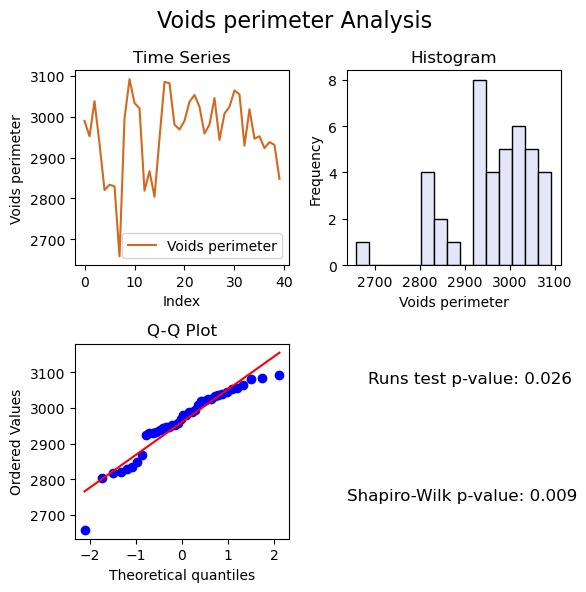

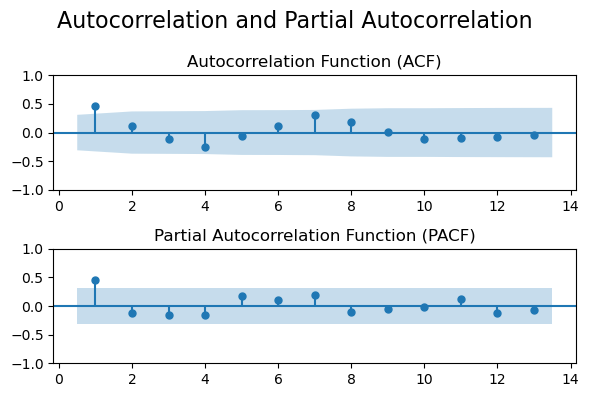

In [69]:
iid_check(new_df["Voids perimeter"], "Voids perimeter")

From statistical tests:
1. **Non-Normal Distribution**:
   - The Shapiro-Wilk test p-value (0.009) indicates that the data is **not normally distributed**.
   
2. **Non-Randomness**:
   - The runs test p-value (0.026) indicates that the data is **not random**, suggesting potential trends or dependencies.


The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots suggest:
  - The presence of autocorrelation in the data.
  - Potential applicability of **ARIMA** modeling to address dependencies. Starting with an **AR(1)** or **MA(1)** model could be appropriate based on the behavior observed.
  - There is a potential **seasonality effect**, which will require further investigation.

We will start by fitting an  AR(1) model to the data:

In [70]:
# We use the SARIMA model to be able to capture potential seasonality effects
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model
model_VP = SARIMAX(
    new_df['Voids perimeter'], 
    order=(1, 0, 0),      # ARIMA order
    seasonal_order=(0, 0, 0, 0),  # Seasonal ARIMA order with lag 4
    trend = 'c'
).fit()

print(model_VP.summary())

                               SARIMAX Results                                
Dep. Variable:        Voids perimeter   No. Observations:                   40
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -232.690
Date:                Mon, 09 Dec 2024   AIC                            471.381
Time:                        12:33:36   BIC                            476.447
Sample:                             0   HQIC                           473.213
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1547.4505    323.311      4.786      0.000     913.773    2181.128
ar.L1          0.4769      0.112      4.270      0.000       0.258       0.696
sigma2      6715.8736   1416.824      4.740      0.0

All the model coefficients are statistically significant. Now we will check residuals for IID:

count     40.000000
mean      -0.346551
std       82.108299
min     -238.616634
25%      -44.856880
50%        5.511298
75%       58.430170
max      180.093277
dtype: float64 

Shapiro-Wilk test p-value: 0.588

Runs test statistic: -1.602
Runs test p-value: 0.109



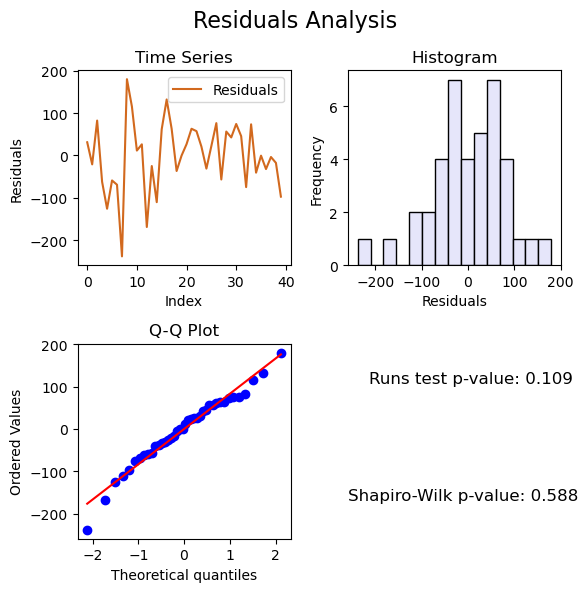

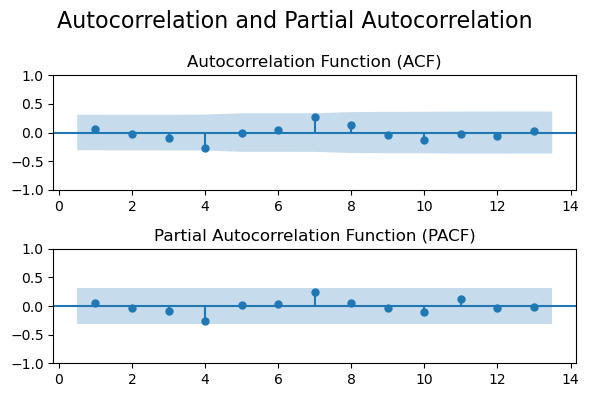

In [71]:
iid_check(model_VP.resid, "Residuals")

**Statistical Testing**: Residuals of the current model are **IID** based on statistical tests.

**ACF and PACF**: Despite residuals being IID, periodic behavior with a **seasonality of period 4** is visible in the ACF and PACF plots.

We can introduce a **seasonal component** with period 4 into the model to account for the observed periodicity.

While IID checks suggest residuals are statistically acceptable, the Runs test shows a borderline value of 0.1, which, combined with the limited number of observations in the dataset, suggests further investigation. Including a seasonal term may:
- Reduce the visible periodicity in the ACF/PACF.
- Enhance model interpretability and forecasting performance.

Let's first identify the nature of this seasonality.

### Seasonality Nature

We place **4 parts** on a tray (Figure 1) and capture an image using a camera positioned approximately at the center of the tray (Figure 2).

<img src="Figs/Fig1.png" alt="Figure 1" width="450">

**Figure 1**: Position of parts on the tray.

<br>

<img src="Figs/Fig2.png" alt="Figure 2" width="500">

**Figure 2**: Differences in angular resolutions of features.

<br>

**Explanation of Observed Seasonality**: 
- The parts are **hemispheres** with triangular-shaped features. When captured from a central viewpoint, the **angular resolution** of the same feature varies depending on the part's position on the tray. This variation introduces a **seasonal effect with a period of 4**, as the features' measured values depend on their relative positions.


Back to the `Voids Perimeter`: we will fit a SARIMA model with a seasonal component to account for the observed periodicity in the data.

In [72]:
# Fit a SARIMA model
model_VP = SARIMAX(
    new_df['Voids perimeter'], 
    order=(1, 0, 0),      # ARIMA order
    seasonal_order=(0, 0, 1, 4),  # Seasonal ARIMA order with lag 4
    trend = 'c'
).fit()

print(model_VP.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     Voids perimeter   No. Observations:                   40
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 4)   Log Likelihood                -231.254
Date:                             Mon, 09 Dec 2024   AIC                            470.507
Time:                                     12:33:37   BIC                            477.263
Sample:                                          0   HQIC                           472.950
                                              - 40                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1547.4256    413.167      3.745      0.000     737.633    2357.218
ar.L1          0.4773      

c:\Users\andre\anaconda3\envs\qda-project-WIN\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


*The coefficients for the seasonal component (P, D, Q) were iteratively selected.*

Let's check the model residuals for IID:

count     40.000000
mean      -0.356394
std       79.163001
min     -255.236345
25%      -50.676892
50%        9.187409
75%       51.344647
max      147.349392
dtype: float64 

Shapiro-Wilk test p-value: 0.129

Runs test statistic: -0.305
Runs test p-value: 0.760



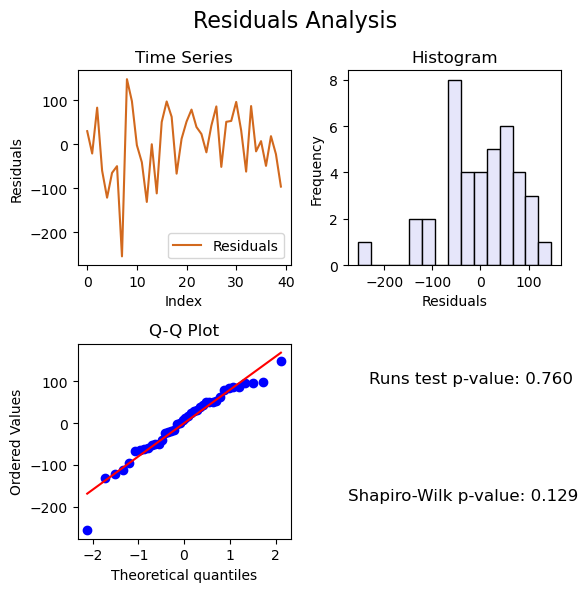

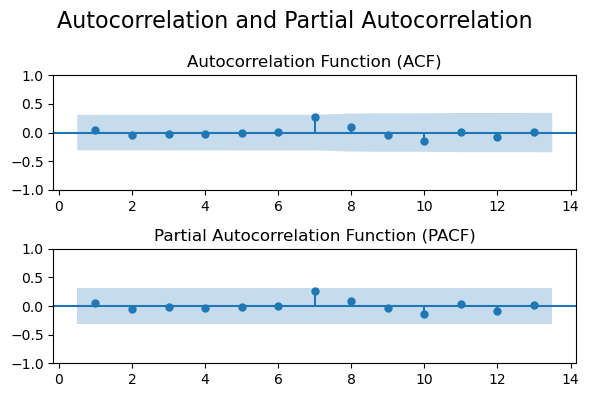

In [73]:
iid_check(model_VP.resid, "Residuals")

The seasonal component has a p-value of 0.124, suggesting it overcomplicates the model without significantly enhancing predictive power. However, its inclusion results in:
- A much higher Runs test p-value for residuals.
- Elimination of the seasonal effect in the ACF and PACF.

**Note**: Despite its statistical insignificance, iterative testing demonstrated that the seasonal term improves the overall performance of the SPC. This suggests that the seasonal term addresses subtle patterns or dependencies not captured by the primary components.

### **Base perimeter**

Let's check the variable `Base perimeter`

count      40.000000
mean     1161.489625
std        20.596906
min      1126.373000
25%      1147.903250
50%      1160.247500
75%      1173.812250
max      1199.087000
Name: Base perimeter, dtype: float64 

Shapiro-Wilk test p-value: 0.318

Runs test statistic: -0.583
Runs test p-value: 0.560



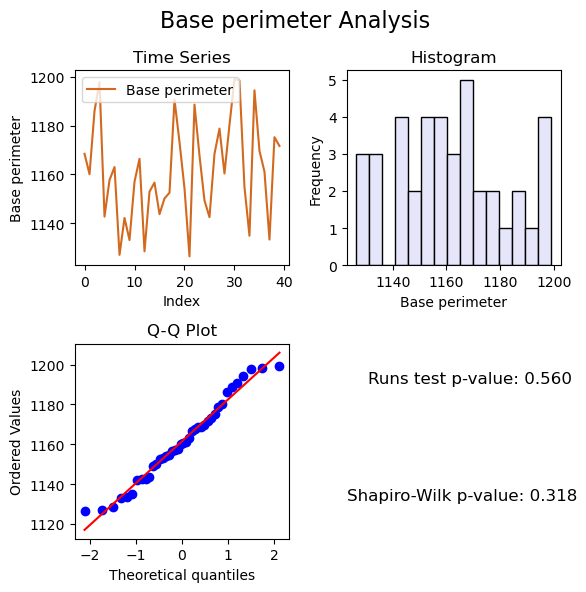

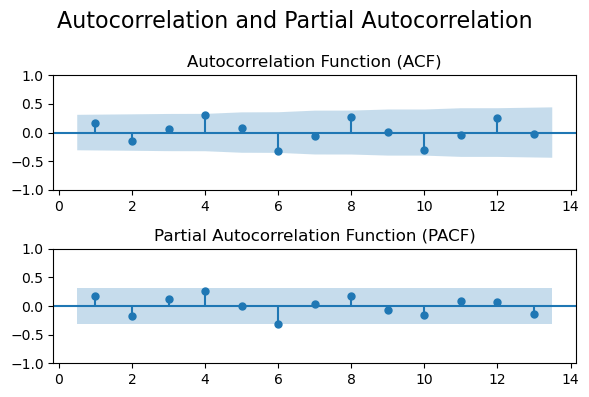

In [74]:
iid_check(new_df["Base perimeter"], "Base perimeter")

The data is confirmed to be IID, with p-values significantly exceeding the threshold.

### **Area**

Let's check the variable `Area`

count       40.000000
mean     11675.525000
std        480.979715
min      10318.000000
25%      11366.750000
50%      11739.000000
75%      12039.500000
max      12583.000000
Name: Area, dtype: float64 

Shapiro-Wilk test p-value: 0.365

Runs test statistic: -2.201
Runs test p-value: 0.028



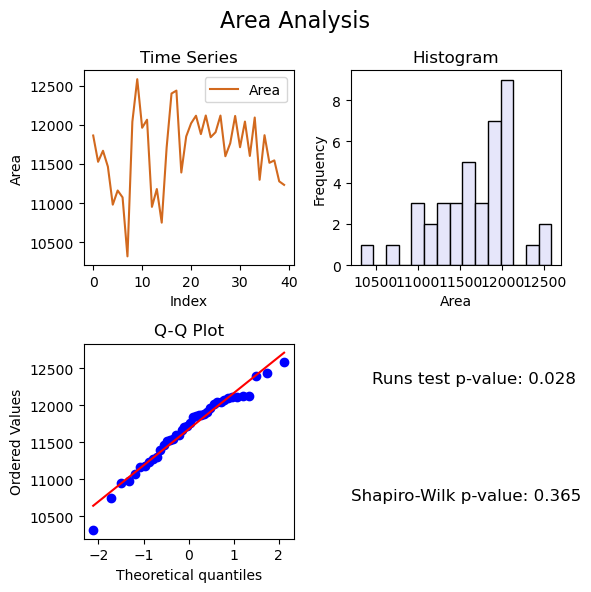

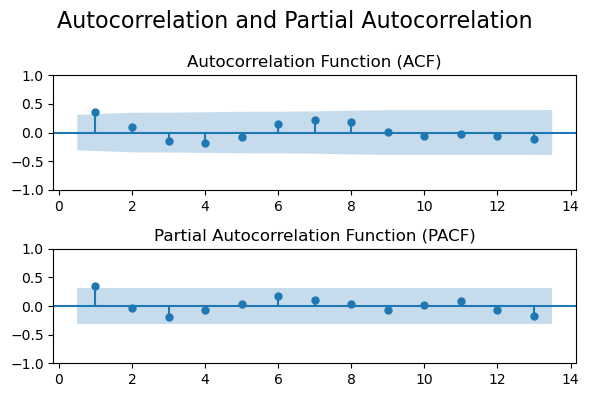

In [75]:
iid_check(new_df["Area"], "Area")

From statistical tests:
1. **Normal Distribution is confirmed**:
   - The Shapiro-Wilk test p-value (0.365) indicates that the data is **normally distributed**.
   
2. **Non-Randomness**:
   - The runs test p-value (0.028) indicates that the data is **not random**, suggesting potential trends or dependencies.


The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots suggest:
  - The presence of autocorrelation in the data.
  - Potential applicability of **ARIMA** modeling to address dependencies. Starting with an **AR(1)** or **MA(1)** model could be appropriate based on the behavior observed.

We will start by fitting an  AR(1) model to the data:

In [76]:
# Fit a SARIMA model
model_A = SARIMAX(
    new_df['Area'], 
    order=(1, 0, 0),      # ARIMA order
    seasonal_order=(0, 0, 0, 4),  # Seasonal ARIMA order with lag 4
    trend = 'c'
).fit()

print(model_A.summary())

                               SARIMAX Results                                
Dep. Variable:                   Area   No. Observations:                   40
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -300.595
Date:                Mon, 09 Dec 2024   AIC                            607.191
Time:                        12:33:38   BIC                            612.257
Sample:                             0   HQIC                           609.023
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7428.9535   1419.295      5.234      0.000    4647.187    1.02e+04
ar.L1          0.3635      0.123      2.951      0.003       0.122       0.605
sigma2      2.006e+05   4.98e+04      4.026      0.0

All the model coefficients are statistically significant. Now we will check residuals for IID:

count      40.000000
mean       -1.616002
std       449.000347
min     -1135.755887
25%      -241.979224
50%        27.192554
75%       337.148740
max       859.331991
dtype: float64 

Shapiro-Wilk test p-value: 0.667

Runs test statistic: -0.305
Runs test p-value: 0.760



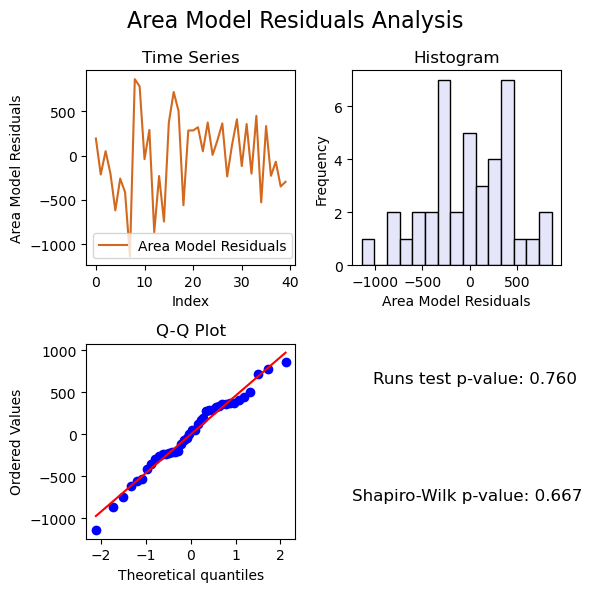

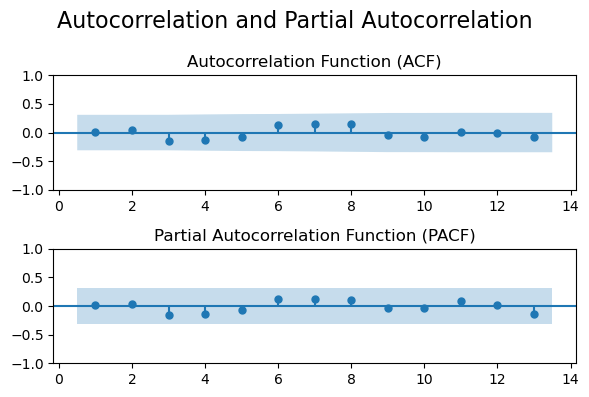

In [77]:
iid_check(model_A.resid, "Area Model Residuals")

Residuals of the current model are **IID** based on statistical tests.


### **Number of voids**
Let's check the variable `Number of voids`. The number of voids is a discrete variable, making the Shapiro-Wilk test inapplicable. To test for normality, we will use the Chi-squared test.

count    40.000000
mean     43.825000
std       1.906635
min      40.000000
25%      42.000000
50%      44.000000
75%      45.000000
max      47.000000
Name: Number of voids, dtype: float64 

Chi-squared test for normality: p-value = 0.016
Runs test statistic = 0.065
Runs test p-value = 0.948


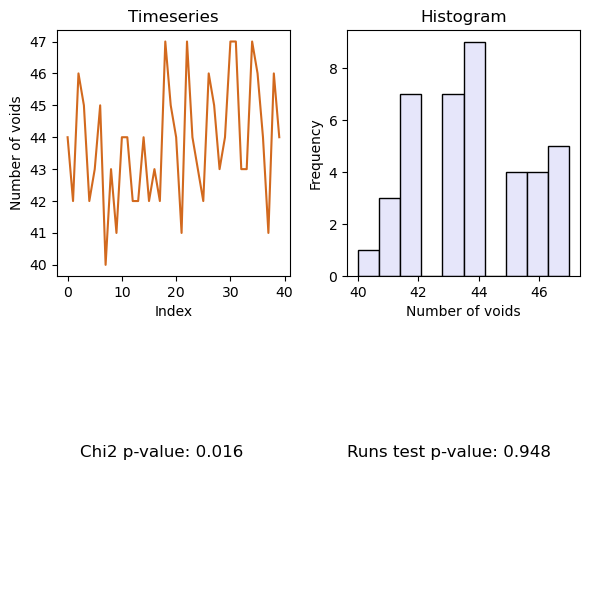

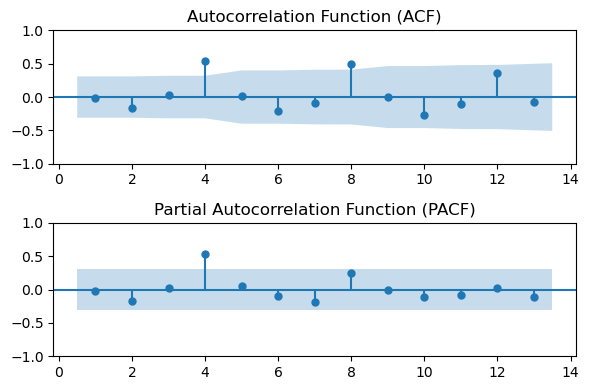

In [78]:
# Specify the column for analysis
column = "Number of voids"

# Get basic statistics
print(new_df[column].describe(), "\n")

# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Plot timeseries
axs[0, 0].plot(new_df[column], label=column, color='#D2691E')
axs[0, 0].set_xlabel('Index')
axs[0, 0].set_ylabel(column)
axs[0, 0].set_title('Timeseries')

# Plot histogram
axs[0, 1].hist(new_df[column], bins=10, edgecolor='black', color='#E6E6FA')
axs[0, 1].set_xlabel(column)
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Histogram')

# Chi-squared test for normality
observed_freq, bins = np.histogram(new_df[column], bins=5)
expected_freq = np.ones_like(observed_freq) * observed_freq.sum() / len(observed_freq)  # Normalize expected freq

# Perform the Chi-Squared test
chi2_stat, p_value_chi2 = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)
print(f'Chi-squared test for normality: p-value = {p_value_chi2:.3f}')

axs[1, 0].text(0.1, 0.5, f'Chi2 p-value: {p_value_chi2:.3f}', fontsize=12, transform=axs[1, 0].transAxes)
axs[1, 0].axis('off')

# Runs test for independence
stat_runs, pval_runs = runstest_1samp(new_df[column], correction=False)
print(f'Runs test statistic = {stat_runs:.3f}')
print(f'Runs test p-value = {pval_runs:.3f}')
axs[1, 1].text(0, 0.5, f'Runs test p-value: {pval_runs:.3f}', fontsize=12, transform=axs[1, 1].transAxes)
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Plot the autocorrelation and partial autocorrelation functions
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
sgt.plot_acf(new_df[column], lags=int(len(new_df) / 3), zero=False, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
sgt.plot_pacf(new_df[column], lags=int(len(new_df) / 3), zero=False, ax=ax[1], method='ywm')
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

From statistical tests:

1. **Normal Distribution**:
   - The Chi-squared test p-value (0.016) shows that the data is **not normally distributed**.

2. **Randomness**:
   - The Runs test p-value (0.948) indicates that the data is **random**. 
   - However, visible **seasonality** is present in the ACF and PACF plots, which suggests that this periodic behavior could be addressed by incorporating a seasonal component into the model.

We will first fit a model with a seasonal component to account for the observed seasonality in the data. After fitting the model, we will verify the residuals for IID.

In [79]:
# Fit a SARIMA model
model_NV = SARIMAX(
    new_df['Number of voids'], 
    order=(0, 0, 0),           # ARIMA order
    seasonal_order=(1, 0, 0, 4),  # Seasonal ARIMA order with lag 4
    trend='c'                  # Include constant trend
).fit()

# Print summary
print(model_NV.summary())

                                SARIMAX Results                                
Dep. Variable:         Number of voids   No. Observations:                   40
Model:             SARIMAX(1, 0, 0, 4)   Log Likelihood                 -74.213
Date:                 Mon, 09 Dec 2024   AIC                            154.426
Time:                         12:33:39   BIC                            159.492
Sample:                              0   HQIC                           156.258
                                  - 40                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.3011      6.897      2.654      0.008       4.784      31.818
ar.S.L4        0.5828      0.157      3.701      0.000       0.274       0.891
sigma2         2.2956      0.490      4.684 

c:\Users\andre\anaconda3\envs\qda-project-WIN\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


All the model coefficients are statistically significant. Now we will check residuals for IID:

count    40.000000
mean     -0.022626
std       1.560769
min      -4.525773
25%      -0.943002
50%       0.096804
75%       1.076901
max       3.056998
dtype: float64 

Shapiro-Wilk test p-value: 0.619

Runs test statistic: 1.622
Runs test p-value: 0.105



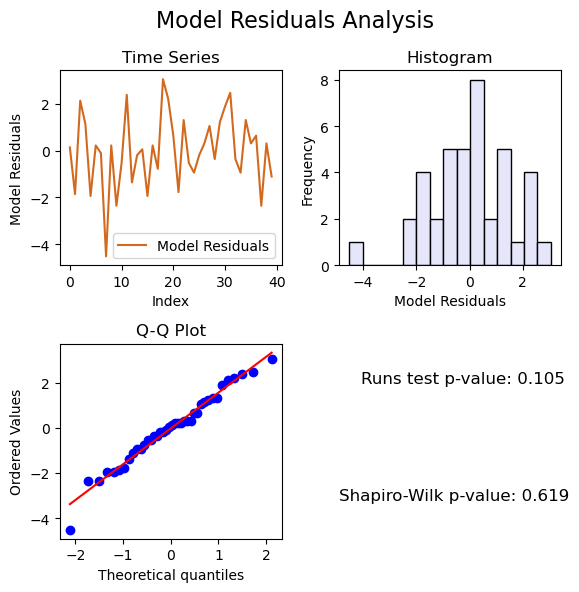

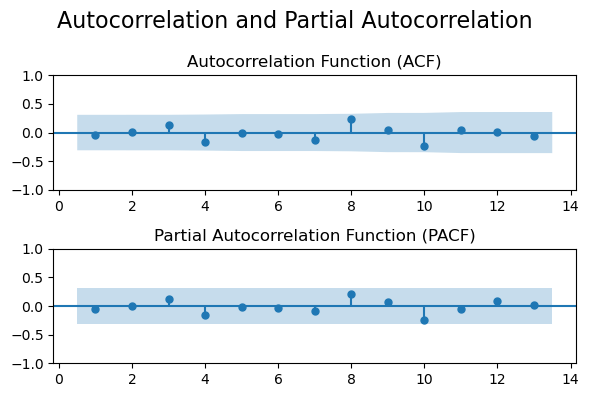

In [80]:
iid_check(model_NV.resid, "Model Residuals")

Residuals of the current model are **IID** based on statistical tests. Elimination of the visual seasonal effect in the ACF and PACF was reached.


## Building Statistical Process Control Charts

### Data preparation

We will first create a dataframe containing only the variables to be monitored:
- `Base Perimeter`.
- Residuals of the models for:
  - `Area`.
  - `Voids perimeter`.
  - `Number of voids`.

In [81]:
# Create a copy of the DataFrame and drop unnecessary columns
# We drop 'Total perimeter' because it is a linear combination of 'Voids perimeter' and 'Base perimeter'
new_df_model = new_df.copy().drop(columns=["Area", "Voids perimeter", "Total perimeter", "Number of voids", "Sample"])

# Add residuals from the models as new columns
new_df_model['Area_m'] = model_A.resid  # Residuals for Area
new_df_model['Voids perimeter_m'] = model_VP.resid  # Residuals for Voids perimeter
new_df_model['Number of voids_m'] = model_NV.resid  # Residuals for Number of voids

new_df_model.head()

,Part name,Base perimeter,Position,Image name,Area_m,Voids perimeter_m,Number of voids_m
0,1_top_left,1168.474,top_left,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...,191.215321,29.271590,0.136610
1,1_bottom_left,1160.106,bottom_left,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...,-214.293699,-21.485240,-1.863390
2,1_top_right,1186.077,top_right,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...,48.846257,82.680481,2.136610
3,1_bottom_right,1197.916,bottom_right,2024-03-26_13-10-04-902_MV540-H@xWyHvMbxwzDCYC...,-205.408903,-60.358716,1.136610
4,2_top_left,1142.692,top_left,2024-03-26_13-10-58-934_MV540-H@xWyHvMbxwzDCYC...,-617.616013,-121.923716,-1.943002


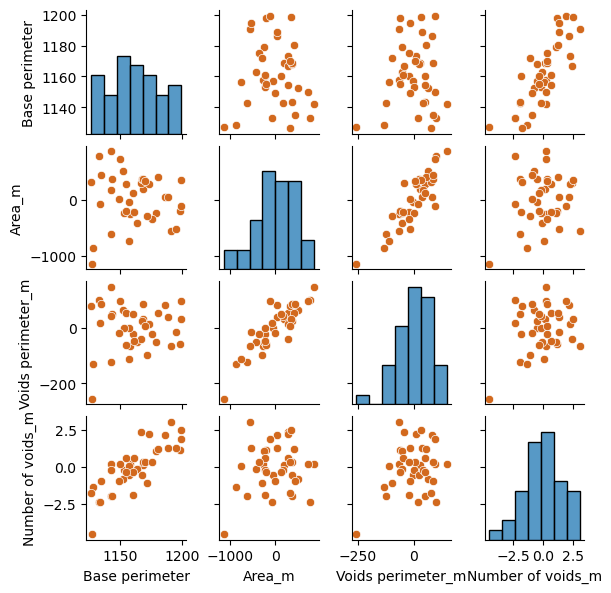

In [82]:
# Let's visually inspect the data with pairplot
sns.pairplot((new_df_model),plot_kws={'color': '#D2691E'}, height=1.5)

Throughout the analysis, we have observed points appearing as **outliers** in the plots. These outliers may introduce noise into the SPC charts. To address this, we will identify and remove them using the **IQR method** and substitude them with the column mean.

In [83]:
# Replace outliers with mean (IQR Method)
def replace_outliers_with_mean_iqr(data):
    for column in data.select_dtypes(include=[np.number]):  # Apply only to numeric columns
        Q1 = np.percentile(data[column], 25)
        Q3 = np.percentile(data[column], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mean = data[column].mean()
        outlier_indices = (data[column] < lower_bound) | (data[column] > upper_bound)  # Identify outliers
        if outlier_indices.any():  # Check if any outliers are present
            print(f"\nOutliers in column '{column}' (IQR Method):")
            print(data.loc[outlier_indices]["Part name"])  # Print rows with outliers
        else:
            print(f"\nNo outliers found in column '{column}'.")
        print(mean)
        # Replace outliers with mean
        data.loc[outlier_indices, column] = mean


# Replace outliers in-place using IQR method
replace_outliers_with_mean_iqr(new_df_model)


No outliers found in column 'Base perimeter'.
1161.4896249999997

Outliers in column 'Area_m' (IQR Method):
7    2_bottom_right
Name: Part name, dtype: object
-1.616002273551294

Outliers in column 'Voids perimeter_m' (IQR Method):
7    2_bottom_right
Name: Part name, dtype: object
-0.3563937356571046

Outliers in column 'Number of voids_m' (IQR Method):
7    2_bottom_right
Name: Part name, dtype: object
-0.022625569501681042


### PCA

Introducing the **PCA method** can help reduce noise and highlight key patterns in the data by transforming it into principal components that capture the most significant variance. This approach:
- Filters out less meaningful variations in the data.
- Helps in building more robust SPC control charts by focusing on the principal sources of variability.

We will apply PCA and construct SPC control charts using the principal components to improve monitoring and anomaly detection.

In [84]:
# Calculate the standard deviation of columns
new_df_model.std()

c:\Users\andre\anaconda3\envs\qda-project-WIN\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Base perimeter        20.596906
Area_m               409.628382
Voids perimeter_m     67.523323
Number of voids_m      1.379509
dtype: float64

The data exhibits high variability in standard deviation. To ensure that all features contribute equally to the PCA, we will standardize the data by scaling each variable to have a mean of 0 and a standard deviation of 1 before applying PCA.

In [85]:
# Standardize the numerical columns by subtracting the mean and dividing by the standard deviation
new_df_model_std = (
    (new_df_model - new_df_model.mean()) / new_df_model.std()
).drop(columns=["Image name", "Part name", "Position"])  # Drop non-numerical columns

# Display descriptive statistics for the standardized DataFrame
new_df_model_std.describe()

c:\Users\andre\anaconda3\envs\qda-project-WIN\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,Area_m,Base perimeter,Number of voids_m,Voids perimeter_m
count,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01
mean,4.440892e-17,1.380840e-14,-2.775558e-18,-1.110223e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.173825e+00,-1.704947e+00,-1.776129e+00,-2.037122e+00
25%,-6.318239e-01,-6.596318e-01,-6.587851e-01,-8.266836e-01
50%,1.110908e-03,-6.030639e-02,4.965991e-03,4.697346e-02
75%,7.577874e-01,5.982755e-01,7.154340e-01,6.713094e-01
max,2.032561e+00,1.825389e+00,2.150798e+00,2.093111e+00


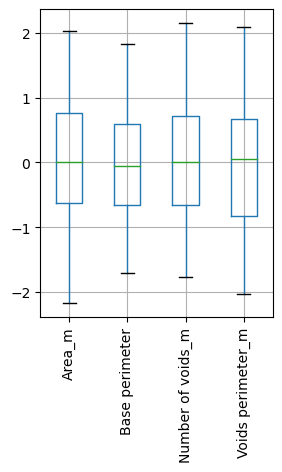

In [86]:
# boxplot of data distribution
new_df_model_std.boxplot(rot = 90, figsize=(3,4))
plt.show()

Let's apply **PCA**:

Eigenvalues from ORIGINAL data 
 [1.95024655 1.68499974 0.22398598 0.14076772]

Eigenvectors from ORIGINAL data 
 [[ 0.58951365 -0.45548216 -0.37433124  0.55216462]
 [-0.38497809 -0.53736459 -0.6057089  -0.44288588]
 [ 0.13528091 -0.67500634  0.68570226 -0.23638514]
 [-0.69711161 -0.21941226  0.15101412  0.66564885]]

Explained variance ratio from ORIGINAL data 
 [0.48756164 0.42124994 0.0559965  0.03519193]

Cumulative explained variance ratio from ORIGINAL data 
 [0.48756164 0.90881157 0.96480807 1.        ]


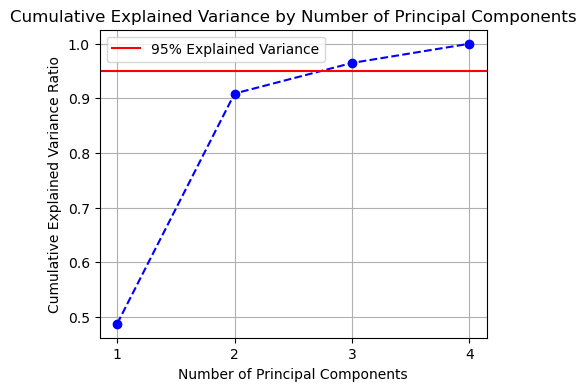

In [87]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(new_df_model_std) 
# Compare the eigenvalues
print("Eigenvalues from ORIGINAL data \n", pca.explained_variance_)

# Compare the eigenvectors
print("\nEigenvectors from ORIGINAL data \n", pca.components_)

# Compare the explained variance ratio
print("\nExplained variance ratio from ORIGINAL data \n", pca.explained_variance_ratio_)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Compare the cumulative explained variance ratio
print("\nCumulative explained variance ratio from ORIGINAL data \n", cumulative_explained_variance)


# Plot the cumulative explained variance ratio
plt.figure(figsize=(5, 4))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker='o',
    linestyle='--',
    color='blue'
)
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.xticks([1,2,3,4])
plt.axhline(y=0.95, color='r', label='95% Explained Variance')  #threshold
plt.legend()
plt.show()

We set a threshold for explained variance at 95% and will use 3 principal components for process monitoring. 

We will compute the PCA scores and select those corresponding to the 3 selected principal components.

In [88]:
# Compute the scores
scores = pca.transform(new_df_model_std)

# create a dataframe with the scores
scores_df = pd.DataFrame(scores, columns = ['z1', 'z2', 'z3','z4'])

#selected scores - we use the first 4 PCs
scores_sel_df = scores_df[['z1', 'z2', 'z3']]

scores_sel_df.head() 

,z1,z2,z3
0,0.259767,-0.509821,-0.232797
1,-0.011124,1.300669,-0.908916
2,-0.440354,-2.063735,-0.049553
3,-1.966409,-0.756384,-0.517824
4,-1.006189,2.827776,-0.159377


We should verify that all principal components scores are IID. While they are expected to be IID because they are derived from IID data, this step ensures reliability. 

count    4.000000e+01
mean     3.885781e-17
std      1.396512e+00
min     -2.893956e+00
25%     -9.748773e-01
50%     -8.426142e-02
75%      7.884007e-01
max      3.121550e+00
Name: z1, dtype: float64 



Shapiro-Wilk test p-value: 0.706

Runs test statistic: -0.947
Runs test p-value: 0.343



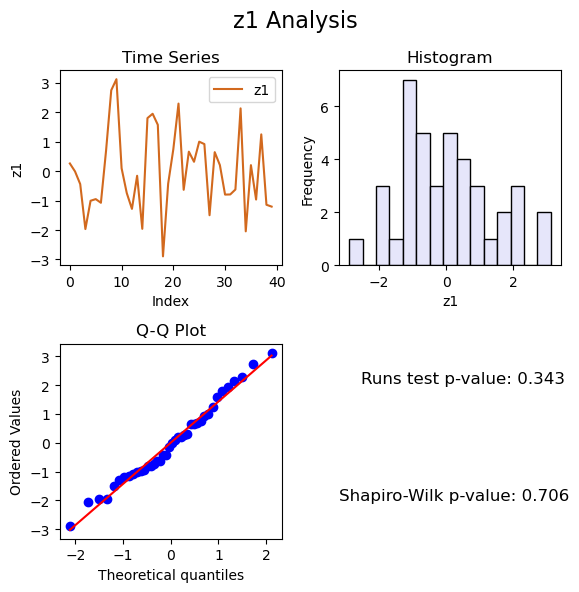

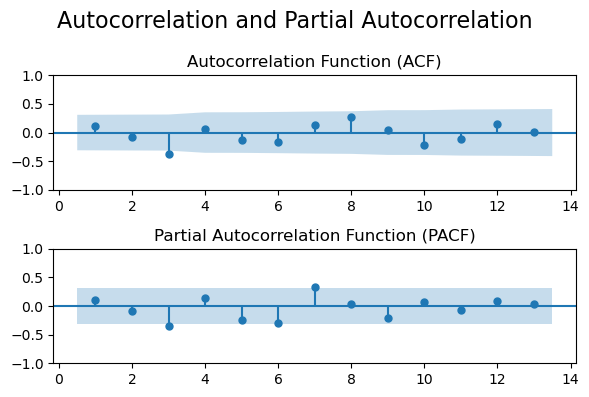

In [89]:
iid_check(scores_sel_df['z1'], "z1")

count    4.000000e+01
mean    -5.551115e-18
std      1.298075e+00
min     -2.485248e+00
25%     -1.011249e+00
50%     -3.298761e-02
75%      8.606818e-01
max      3.238001e+00
Name: z2, dtype: float64 

Shapiro-Wilk test p-value: 0.822

Runs test statistic: -1.602
Runs test p-value: 0.109



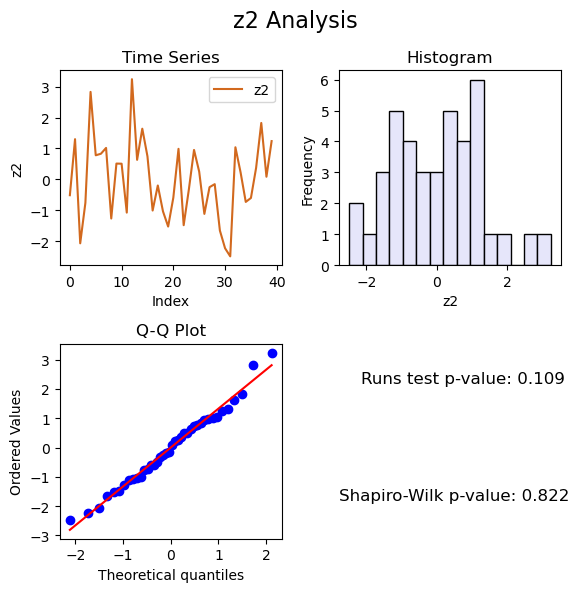

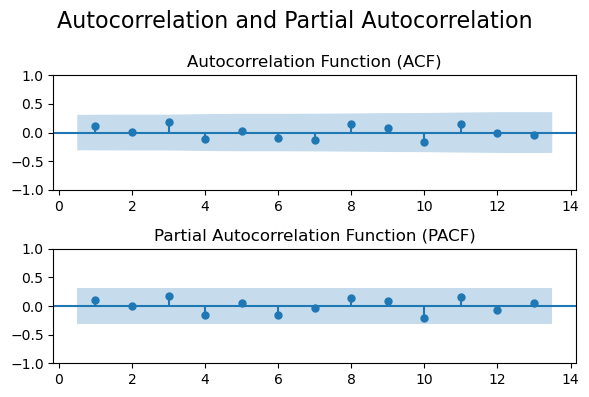

In [90]:
iid_check(scores_sel_df['z2'], "z2")

count    4.000000e+01
mean     4.163336e-17
std      4.732716e-01
min     -9.089159e-01
25%     -3.601378e-01
50%     -5.500354e-02
75%      3.465851e-01
max      1.233074e+00
Name: z3, dtype: float64 

Shapiro-Wilk test p-value: 0.532

Runs test statistic: -0.508
Runs test p-value: 0.611



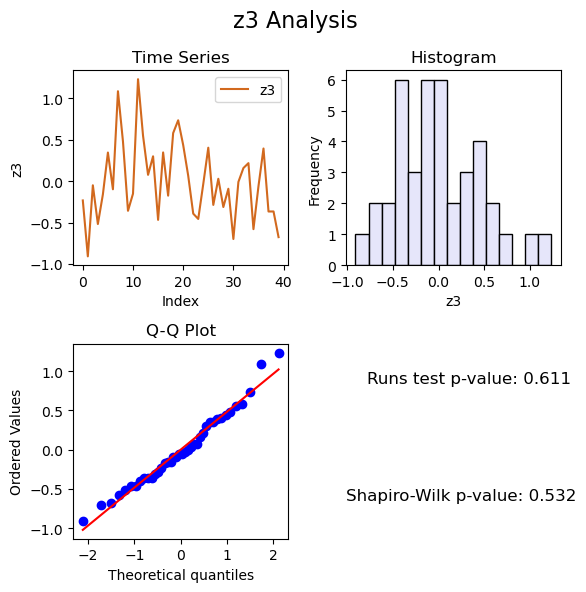

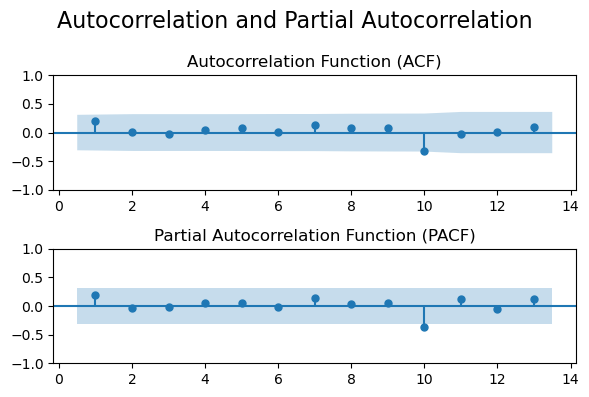

In [91]:
iid_check(scores_sel_df['z3'], "z3")

All the selected principal components are confirmed to be **IID**.

The following visualization highlights the contributions of each variable to the principal components. The inspection indicates that all variables are equally important for the PCs.

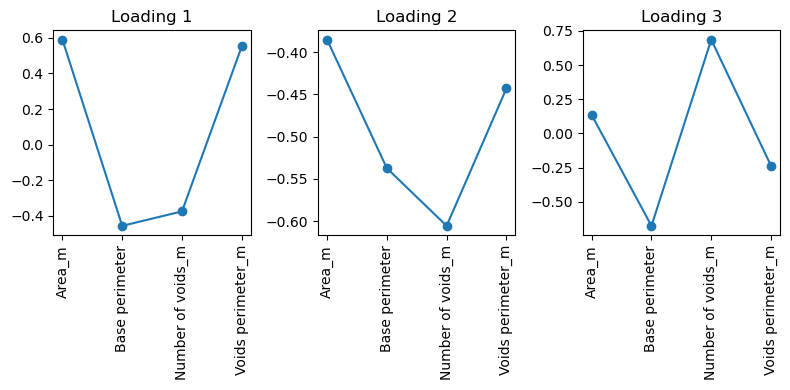

In [92]:
# Plot the loadings
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
for i in range(3):
    ax[i].plot(pca.components_[i], 'o-')
    ax[i].set_title(f'Loading {i + 1}')
    ax[i].set_xticks(range(len(new_df_model_std.columns)))  # Set positions for ticks
    ax[i].set_xticklabels(new_df_model_std.columns, rotation=90)  # Set tick labels with 90-degree rotation

plt.tight_layout()
plt.show()

### Control Charts Creation

We will create and plot the following control charts:
- **3 I-MR Univariate Control Charts**: One for each of the 3 principal components.
- **T² Multivariate Control Charts**: For monitoring the 3 principal components.
- **T² Multivariate Control Charts**: For monitoring the 4 original variables.

Before proceeding, we need to determine the family-wise alpha level. The analysis to identify the optimal alpha is detailed in **Appendix 1**. We set the family-wise alpha level to **0.005**.

In [93]:
alpha_f = 0.01  # Fanily-wise significance level
k = 3 # Number of tests

# Adjusted alpha for each test
alpha = 1 - (1 - alpha_f)**(1/k)

# Critical value for the normal distribution
K_alpha = stats.norm.ppf(1 - alpha/2)

print(f"Family-wise alpha : {alpha_f:.5f}")
print(f"Adjusted alpha for {k} tests: {alpha:.5f}")
print(f"Critical value (K_alpha): {K_alpha:.5f}")

Family-wise alpha : 0.01000
Adjusted alpha for 3 tests: 0.00334
Critical value (K_alpha): 2.93416


#### **Z1** I-MR Control Chart

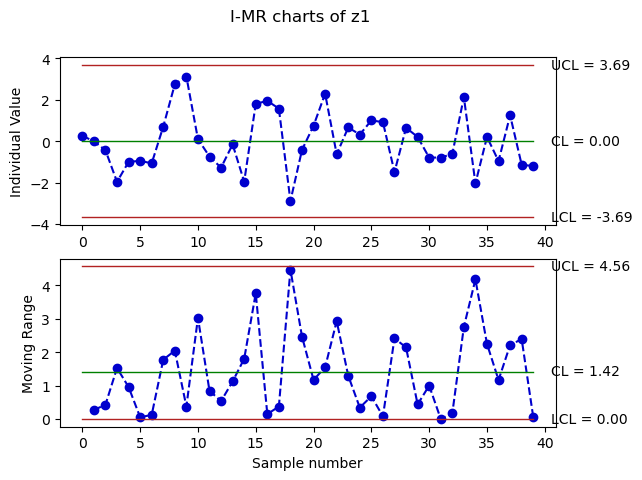

In [94]:
data_IMR = qda.ControlCharts.IMR(scores_sel_df, 'z1',K=K_alpha)

There are no out-of-control (OOC) points in the Phase 1 part of this control chart. We consider the design of this control chart complete.

#### **Z2** I-MR Control Chart

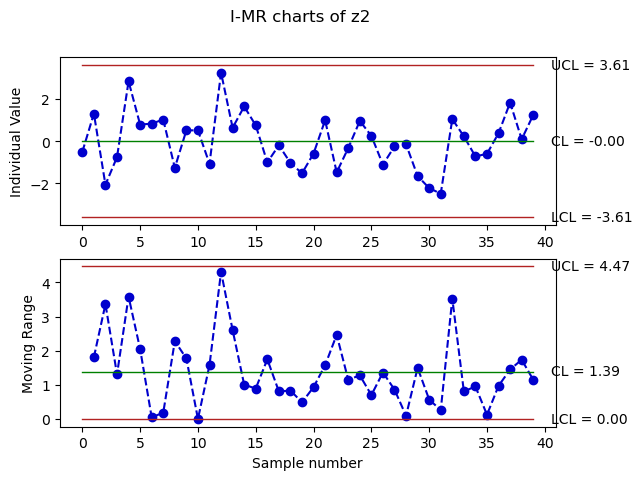

In [95]:
data_IMR = qda.ControlCharts.IMR(scores_sel_df, 'z2',K=K_alpha)

There are no out-of-control (OOC) points in the Phase 1 part of this control chart. We consider the design of this control chart complete.

#### **Z3** I-MR Control Chart

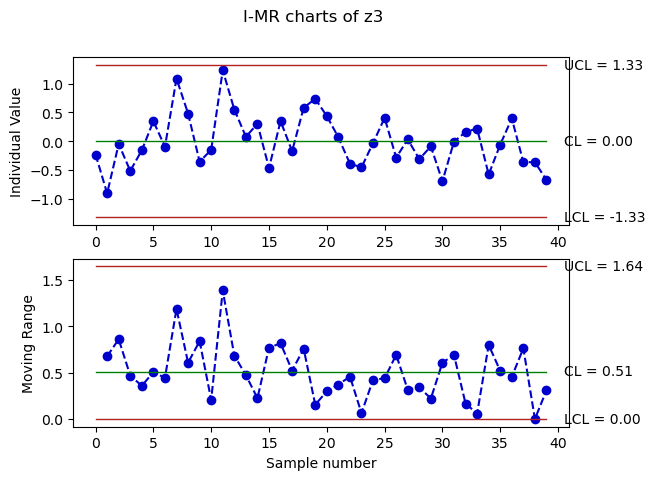

In [96]:
data_IMR = qda.ControlCharts.IMR(scores_sel_df, 'z3',K=K_alpha)

There are no out-of-control (OOC) points in the Phase 1 part of this control chart. We consider the design of this control chart complete.

#### **T²** Control Chart Built on PCA 

In addition to implementing individual control charts for each principal component, we will also utilize the **Hotelling's T² control chart**. The T² chart provides a multivariate monitoring approach, allowing us to detect variations that may not be apparent in individual control charts. This strategy may enhance our ability to identify faults, ensuring a more robust and comprehensive analysis of the process.

T2 CC contains some OOC points. As no assignable cause can be identified, we will delete this point and rebuild the control chart without it.
This process will be repeated iteratively, removing any additional OOC points and refining the control chart, until the Phase 1 section is free from OOC points and the process is stable.



Iteration  1 :
The short-range estimator is: 
           z1        z2        z3
z1  1.721572  0.142060 -0.056078
z2  0.142060  1.482245 -0.104260
z3 -0.056078 -0.104260  0.173382
Number of samples (m): 40


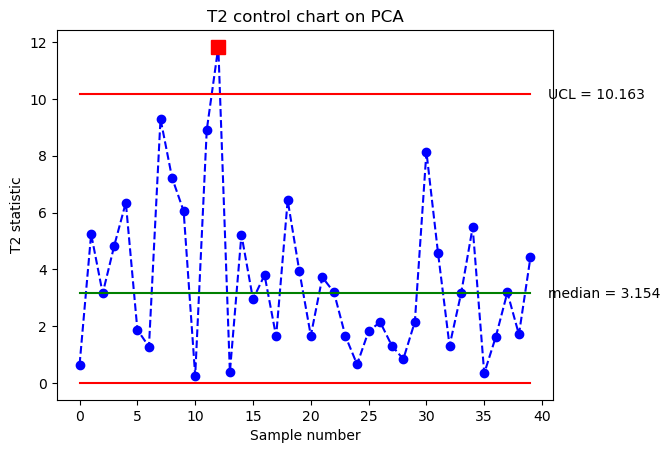

OOC points:
12    4_top_left
Name: Part name, dtype: object


Iteration  2 :
The short-range estimator is: 
           z1        z2        z3
z1  1.701666  0.209269 -0.053958
z2  0.209269  1.157124 -0.082302
z3 -0.053958 -0.082302  0.164524
Number of samples (m): 40


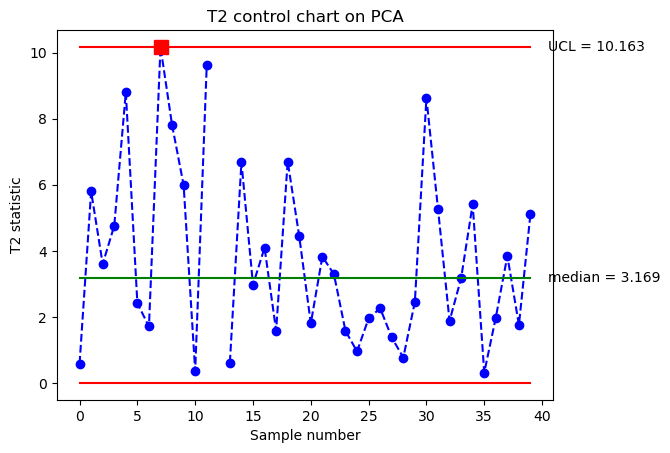

OOC points:
7    2_bottom_right
Name: Part name, dtype: object


Iteration  3 :
The short-range estimator is: 
           z1        z2        z3
z1  1.607627  0.264796 -0.065016
z2  0.264796  1.089985 -0.102914
z3 -0.065016 -0.102914  0.141779
Number of samples (m): 40


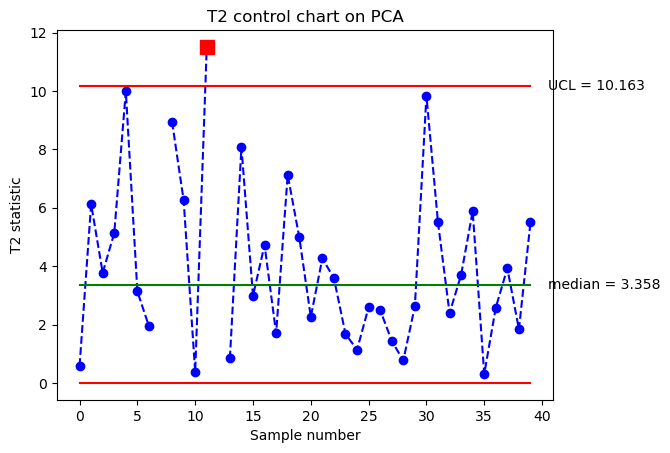

OOC points:
11    3_bottom_right
Name: Part name, dtype: object


Iteration  4 :
The short-range estimator is: 
           z1        z2        z3
z1  1.598511  0.247721 -0.050053
z2  0.247721  1.058000 -0.074885
z3 -0.050053 -0.074885  0.117217
Number of samples (m): 40


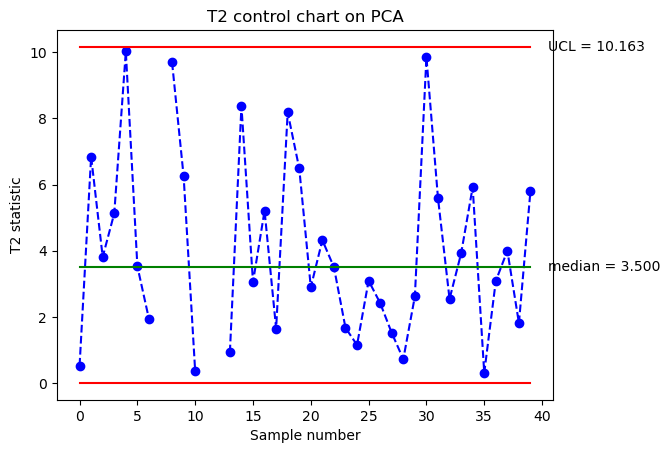

In [97]:
del_from_pca_t2 = []
OOC_idx_T2_pca_ph1 = [None]
iteration = 0

while len(OOC_idx_T2_pca_ph1) > 0:
    
    iteration += 1
    print('\n\nIteration ', iteration, ':')

    scores_sel_df_t2pca = scores_sel_df.copy()
    scores_sel_df_t2pca.loc[del_from_pca_t2] = None
    
    # Check that not too many points were deleted
    if len(scores_sel_df_t2pca[scores_sel_df_t2pca.isna().any(axis = 1)]) > 10:
        
        # save the latest model parameters
        V_pca = V
        S2_pca = S2
        Xbar_pca = Xbar
        S2_inv_pca = S2_inv
        UCL_pca = data_CC['T2_UCL'][0]
        
        break


    # Constants
    n = 1  # Sample size
    m = len(scores_sel_df_t2pca)  # Number of samples
    p = 3  # Number of variables

    # Calculate the difference matrix (V)
    V = scores_sel_df_t2pca.diff().dropna()

    # Calculate the short-range estimator S2
    S2 = (1 / 2) * V.T.dot(V) / (m - 1)

    # Display the short-range estimator
    print("The short-range estimator is: \n", S2)
    print("Number of samples (m):", m)

    # Significance level for control limits
    alpha = alpha_f

    # Calculate the mean vector Xbar
    Xbar = scores_sel_df_t2pca.mean()

    # Invert the S2 matrix
    S2_inv = np.linalg.inv(S2)

    # Calculate the Hotelling T² statistic
    data_CC = pd.DataFrame(columns=['T2'])
    for i in range(m):
        deviation = scores_sel_df_t2pca.iloc[i] - Xbar
        data_CC.loc[i, 'T2'] = n * deviation.T.dot(S2_inv).dot(deviation)

    # Add Upper Control Limit (UCL), Center Line (CL), and Lower Control Limit (LCL)
    data_CC['T2_UCL'] = ((m - 1) ** 2) / m * stats.beta.ppf(1 - alpha, p / 2, (m - p - 1) / 2)
    data_CC['T2_CL'] = data_CC['T2'].median()
    data_CC['T2_LCL'] = 0  # Hotelling T² control chart has a zero lower limit

    # Flag samples exceeding the UCL
    data_CC['T2_TEST'] = np.where(data_CC['T2'] > data_CC['T2_UCL'], data_CC['T2'], np.nan)


    # Plot the T² control chart
    plt.title('T2 control chart on PCA')
    plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
    plt.plot(data_CC['T2_UCL'], color='r')
    plt.plot(data_CC['T2_CL'], color='g')
    plt.plot(data_CC['T2_LCL'], color='r')
    plt.ylabel('T2 statistic')
    plt.xlabel('Sample number')
    # add the values of the control limits on the right side of the plot
    plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
    plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
    # highlight the points that violate the alarm rules
    plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
    plt.show()

    # Identify Out of Control (OOC) points in the T2 chart
    OOC_idx_T2_pca_ph1 = np.where(data_CC['T2_TEST'].notnull())[0]
    
    if len(OOC_idx_T2_pca_ph1) > 0:

        # Retrieve and print the part names corresponding to the OOC indices
        print("OOC points:")
        print(new_df_model.iloc[OOC_idx_T2_pca_ph1]['Part name'])

        del_from_pca_t2 += list(OOC_idx_T2_pca_ph1)
    
    if len(OOC_idx_T2_pca_ph1) == 0: # Save the final CC parameters
        V_pca = V
        S2_pca = S2
        Xbar_pca = Xbar
        S2_inv_pca = S2_inv
        UCL_pca = data_CC['T2_UCL'][0]

No further OOC points are present in the Phase 1 part of the control chart. We consider the design of this control chart complete.


#### **T²** Control Chart Built on Original Data 

We will also construct a multivariate **Hotelling's T² control chart** using the full dataset of original variables (not the principal components). Later, we will compare its performance against the other control charts to evaluate their effectiveness in fault detection.

T2 CC contains some OOC points. As no assignable cause can be identified, we will delete this point and rebuild the control chart without it.
This process will be repeated iteratively, removing any additional OOC points and refining the control chart, until the Phase 1 section is free from OOC points and the process is stable.



Iteration  1 :
The short-range estimator is: 
                      Area_m  Base perimeter  Number of voids_m  \
Area_m             0.903922       -0.158738          -0.046184   
Base perimeter    -0.158738        0.825920           0.762389   
Number of voids_m -0.046184        0.762389           1.045618   
Voids perimeter_m  0.660545       -0.102488          -0.019090   

                   Voids perimeter_m  
Area_m                      0.660545  
Base perimeter             -0.102488  
Number of voids_m          -0.019090  
Voids perimeter_m           0.769124  
Number of samples (m): 40


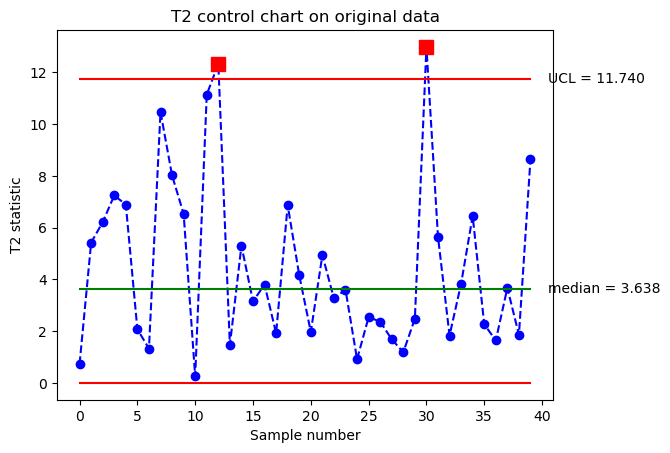

OOC points:
12     4_top_left
30    8_top_right
Name: Part name, dtype: object


Iteration  2 :
The short-range estimator is: 
                      Area_m  Base perimeter  Number of voids_m  \
Area_m             0.733708       -0.233363          -0.159110   
Base perimeter    -0.233363        0.753551           0.679748   
Number of voids_m -0.159110        0.679748           0.936512   
Voids perimeter_m  0.598800       -0.171398          -0.085357   

                   Voids perimeter_m  
Area_m                      0.598800  
Base perimeter             -0.171398  
Number of voids_m          -0.085357  
Voids perimeter_m           0.680957  
Number of samples (m): 40


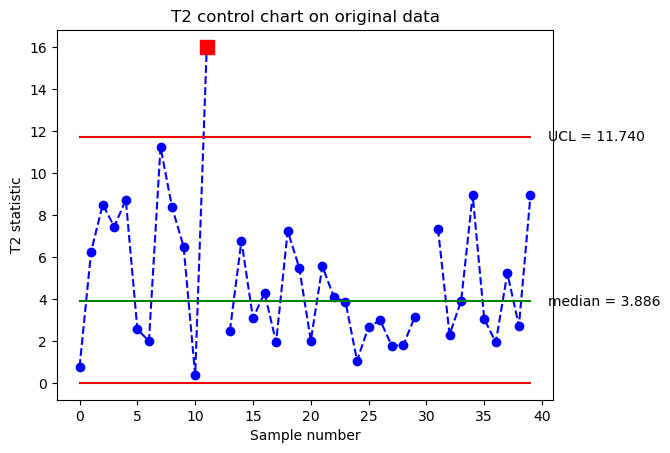

OOC points:
11    3_bottom_right
Name: Part name, dtype: object


Iteration  3 :
The short-range estimator is: 
                      Area_m  Base perimeter  Number of voids_m  \
Area_m             0.725451       -0.238068          -0.180842   
Base perimeter    -0.238068        0.750870           0.667365   
Number of voids_m -0.180842        0.667365           0.879312   
Voids perimeter_m  0.604714       -0.168028          -0.069792   

                   Voids perimeter_m  
Area_m                      0.604714  
Base perimeter             -0.168028  
Number of voids_m          -0.069792  
Voids perimeter_m           0.676721  
Number of samples (m): 40


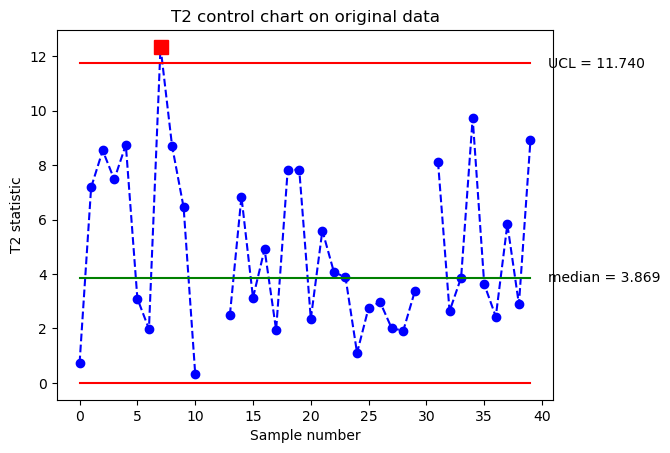

OOC points:
7    2_bottom_right
Name: Part name, dtype: object


Iteration  4 :
The short-range estimator is: 
                      Area_m  Base perimeter  Number of voids_m  \
Area_m             0.655839       -0.235302          -0.186435   
Base perimeter    -0.235302        0.704666           0.667088   
Number of voids_m -0.186435        0.667088           0.878858   
Voids perimeter_m  0.536237       -0.172061          -0.075367   

                   Voids perimeter_m  
Area_m                      0.536237  
Base perimeter             -0.172061  
Number of voids_m          -0.075367  
Voids perimeter_m           0.608370  
Number of samples (m): 40


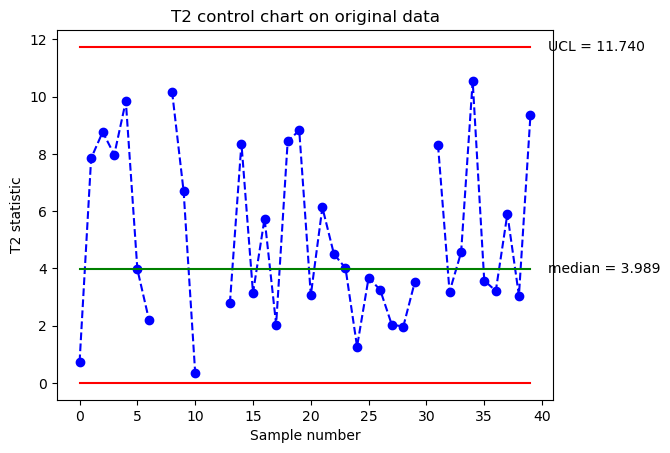

In [98]:
del_from_orig_t2 = []
OOC_idx_T2_orig_ph1 = [None]
iteration = 0

while len(OOC_idx_T2_orig_ph1) > 0:

    iteration += 1
    print('\n\nIteration ', iteration, ':')

    new_df_model_std_t2orig = new_df_model_std.copy()
    new_df_model_std_t2orig.loc[del_from_orig_t2] = None
    
    # Check that not too many points were deleted
    if len(new_df_model_std_t2orig[new_df_model_std_t2orig.isna().any(axis = 1)]) > 10:
        
        # save the latest model parameters
        V_orig = V
        S2_orig = S2
        Xbar_orig = Xbar
        S2_inv_orig = S2_inv
        UCL_orig = data_CC['T2_UCL'][0]
        
        break

    # Constants
    n = 1  # Sample size
    m = len(new_df_model_std_t2orig)  # Number of samples
    p = 4  # Number of variables

    # Calculate the difference matrix (V)
    V = new_df_model_std_t2orig.diff().dropna()

    # Calculate the short-range estimator S2
    S2 = (1 / 2) * V.T.dot(V) / (m - 1)

    # Display the short-range estimator
    print("The short-range estimator is: \n", S2)
    print("Number of samples (m):", m)

    # Significance level for control limits
    alpha = alpha_f

    # Calculate the mean vector Xbar
    Xbar = new_df_model_std_t2orig.mean()

    # Invert the S2 matrix
    S2_inv = np.linalg.inv(S2)

    # Calculate the Hotelling T² statistic
    data_CC = pd.DataFrame(columns=['T2'])
    for i in range(m):
        deviation = new_df_model_std_t2orig.iloc[i] - Xbar
        data_CC.loc[i, 'T2'] = n * deviation.T.dot(S2_inv).dot(deviation)

    # Add Upper Control Limit (UCL), Center Line (CL), and Lower Control Limit (LCL)
    data_CC['T2_UCL'] = ((m - 1) ** 2) / m * stats.beta.ppf(1 - alpha, p / 2, (m - p - 1) / 2)
    data_CC['T2_CL'] = data_CC['T2'].median()
    data_CC['T2_LCL'] = 0  # Hotelling T² control chart has a zero lower limit

    # Flag samples exceeding the UCL
    data_CC['T2_TEST'] = np.where(data_CC['T2'] > data_CC['T2_UCL'], data_CC['T2'], np.nan)

    # Plot the T² control chart
    plt.title('T2 control chart on original data')
    plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
    plt.plot(data_CC['T2_UCL'], color='r')
    plt.plot(data_CC['T2_CL'], color='g')
    plt.plot(data_CC['T2_LCL'], color='r')
    plt.ylabel('T2 statistic')
    plt.xlabel('Sample number')
    # add the values of the control limits on the right side of the plot
    plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
    plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
    # highlight the points that violate the alarm rules
    plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
    plt.show()
    
    # Identify Out of Control (OOC) points in the T2 chart
    OOC_idx_T2_orig_ph1 = np.where(data_CC['T2_TEST'].notnull())[0]
    
    if len(OOC_idx_T2_orig_ph1) > 0:

        # Retrieve and print the part names corresponding to the OOC indices
        print("OOC points:")
        print(new_df_model.iloc[OOC_idx_T2_orig_ph1]['Part name'])

        del_from_orig_t2 += list(OOC_idx_T2_orig_ph1)
    
    if len(OOC_idx_T2_orig_ph1) == 0: # Save the final CC parameters
        V_orig = V
        S2_orig = S2
        Xbar_orig = Xbar
        S2_inv_orig = S2_inv
        UCL_orig = data_CC['T2_UCL'][0]

No further OOC points are present in the Phase 1 part of the control chart. We consider the design of this control chart complete.

With this, we conclude the design stage of the Statistical Process Control.

# Phase 2
---

## Data Preparation

In this phase, we will implement the control charts on new data to identify faulty parts.

Manually acquired list of actual faulty parts:
- **1_top_right**
- **2_top_left**
- **4_bottom_left**
- **4_top_right**
- **6_top_left**
- **7_top_right**
- **7_bottom_left**
- **9_bottom_right**
- **10_top_right**

This list serves as a reference to validate the performance of the implemented control charts.

The dataset obtained through the image analysis function is restructured to match the format used in Phase 1.

In [99]:
import pandas as pd

# Load the dataset
csv_file_path = 'dataset_phase2/Result_phase2/image_statistics_phase2.csv'
df_phase2 = pd.read_csv(csv_file_path)

# Initialize a new data structure to store the required parameters
new_df_phase2 = {
    "Part name": [],
    "Area": [],
    "Voids perimeter": [],
    "Total perimeter": [],
    "Base perimeter": [],
    "Number of voids": [],
    "Position": [],
    "Sample": [],
    "Image name": [],
}

# Initialize variables
sample_count = 0
position_list = ["top_left", "bottom_left", "top_right", "bottom_right"]

# Iterate through each unique image in the dataset
for image_name in df_phase2["Image name"].unique():
    # Increment the sample count for each new image
    sample_count += 1

    # Process data for each position in the image
    for position in position_list:
        # Filter dataset for the current image and position
        part_data = df_phase2[(df_phase2["Image name"] == image_name) & (df_phase2["Position"] == position)]

        if part_data.empty:
            # Skip if no data exists for this position
            continue

        # Calculate the sum of areas and perimeters of the voids (excluding the first row with ID == 0)
        void_areas = part_data["Area [pixels]"][1:]
        void_perimeters = part_data["Perimeter [pixels]"][1:]

        total_area = void_areas.sum()
        total_void_perimeter = void_perimeters.sum()

        # Extract total perimeter for the part (row with ID == 0)
        total_perimeter = part_data[part_data["ID"] == 0]["Perimeter [pixels]"].values[0]
        base_perimeter = total_perimeter - total_void_perimeter

        # Append the processed data to the dictionary
        new_df_phase2["Part name"].append(f"{sample_count}_{position}")
        new_df_phase2["Area"].append(total_area)
        new_df_phase2["Voids perimeter"].append(total_void_perimeter)
        new_df_phase2["Total perimeter"].append(total_perimeter)
        new_df_phase2["Base perimeter"].append(base_perimeter)
        new_df_phase2["Number of voids"].append(len(void_areas))
        new_df_phase2["Position"].append(position)
        new_df_phase2["Sample"].append(sample_count)
        new_df_phase2["Image name"].append(image_name)

# Convert the dictionary to a DataFrame
new_df_phase2 = pd.DataFrame(new_df_phase2)

new_df_phase2.head()

,Part name,Area,Voids perimeter,Total perimeter,Base perimeter,Number of voids,Position,Sample,Image name
0,1_top_left,11401,2899.257,4039.809,1140.552,41,top_left,1,2024-05-22_17-09-23-718_MV540-H@EOaAFjS1zEFNUI...
1,1_bottom_left,12100,3028.740,4188.159,1159.419,42,bottom_left,1,2024-05-22_17-09-23-718_MV540-H@EOaAFjS1zEFNUI...
2,1_top_right,11447,2939.269,4130.904,1191.635,45,top_right,1,2024-05-22_17-09-23-718_MV540-H@EOaAFjS1zEFNUI...
3,1_bottom_right,11720,2951.750,4118.277,1166.527,44,bottom_right,1,2024-05-22_17-09-23-718_MV540-H@EOaAFjS1zEFNUI...
4,2_top_left,11540,2924.481,4075.147,1150.666,42,top_left,2,2024-05-22_17-10-22-455_MV540-H@EOaAFjS1zEFNUI...


We will predict the next 40 values using the models and calculate the residuals for variables: `Area`, `Voids Perimeter` and `Number of Voids`. For `Base perimeter` we will keep the original value.

These residuals will be used for monitoring and identifying faulty parts in the new data.

Residuals for `Voids perimeter`:

In [100]:
# Forecast for the new data using `model_VP`
start_index = len(new_df)  # Prediction starts after the training data
end_index = start_index + len(new_df_phase2) - 1

# Generate predictions for the new data
predictions_phase2 = model_VP.predict(start=start_index, end=end_index).reset_index(drop=True)

# Calculate residuals
residuals_phase2 = new_df_phase2['Voids perimeter'] - predictions_phase2

# Add residuals to the new DataFrame
new_df_phase2['Voids perimeter_m'] = residuals_phase2

Residuals for `Area`:

In [101]:
# Forecast for the new data using `model_A`
start_index = len(new_df)  # Prediction starts after the training data
end_index = start_index + len(new_df_phase2) - 1

# Generate predictions for the new data
predictions_phase2 = model_A.predict(start=start_index, end=end_index).reset_index(drop=True)

# Calculate residuals
residuals_phase2 = new_df_phase2['Area'] - predictions_phase2

# Add residuals to the new DataFrame
new_df_phase2['Area_m'] = residuals_phase2

Residuals for `Number of voids`:

In [102]:
# Forecast for the new data using `model_NV`
start_index = len(new_df)  # Prediction starts after the training data
end_index = start_index + len(new_df_phase2) - 1

# Generate predictions for the new data
predictions_phase2 = model_NV.predict(start=start_index, end=end_index).reset_index(drop=True)

# Calculate residuals
residuals_phase2 = new_df_phase2['Number of voids'] - predictions_phase2

# Add residuals to the new DataFrame
new_df_phase2['Number of voids_m'] = residuals_phase2

Next, we will create a dataframe that mirrors the structure of the modeled Phase 1 data.

In [103]:
# Create a new dataset by dropping unrequired columns
new_df_phase2_model = new_df_phase2.drop(columns = ['Area', 'Voids perimeter', 'Number of voids', "Total perimeter"])
new_df_phase2_model.head()

,Part name,Base perimeter,Position,Sample,Image name,Voids perimeter_m,Area_m,Number of voids_m
0,1_top_left,1140.552,top_left,1,2024-05-22_17-09-23-718_MV540-H@EOaAFjS1zEFNUI...,-20.286693,-110.917770,-2.943002
1,1_bottom_left,1159.419,bottom_left,1,2024-05-22_17-09-23-718_MV540-H@EOaAFjS1zEFNUI...,92.660008,486.328825,-0.194691
2,1_top_right,1191.635,top_right,1,2024-05-22_17-09-23-718_MV540-H@EOaAFjS1zEFNUI...,-15.435728,-203.659736,-0.108543
3,1_bottom_right,1166.527,bottom_right,1,2024-05-22_17-09-23-718_MV540-H@EOaAFjS1zEFNUI...,-31.189069,55.894487,0.056998
4,2_top_left,1150.666,top_left,2,2024-05-22_17-10-22-455_MV540-H@EOaAFjS1zEFNUI...,-46.555780,-128.993212,-1.909786


We will combine the data from Phase 1 and Phase 2 into a single unified dataframe.

In [104]:
# Concat the data from phase 2 with data from phase 1
full_df_model = pd.concat([new_df_model,new_df_phase2_model],ignore_index=True)
full_df_model.tail()

,Part name,Base perimeter,Position,Image name,Area_m,Voids perimeter_m,Number of voids_m,Sample
75,9_bottom_right,1195.739,bottom_right,2024-05-22_17-22-06-952_MV540-H@EOaAFjS1zEFNUI...,181.215321,57.66359,-0.864449,9.0
76,10_top_left,1167.392,top_left,2024-05-22_17-22-26-218_MV540-H@EOaAFjS1zEFNUI...,778.215321,120.14059,0.135993,10.0
77,10_bottom_left,1170.252,bottom_left,2024-05-22_17-22-26-218_MV540-H@EOaAFjS1zEFNUI...,759.215321,137.26359,-1.850453,10.0
78,10_top_right,1213.458,top_right,2024-05-22_17-22-26-218_MV540-H@EOaAFjS1zEFNUI...,-102.784679,24.00359,6.126956,10.0
79,10_bottom_right,1226.329,bottom_right,2024-05-22_17-22-26-218_MV540-H@EOaAFjS1zEFNUI...,233.215321,50.65959,3.135993,10.0


To apply the PCA transformation, the data must be standardized using the **mean** and **standard deviation** calculated from the Phase 1 data.

In [105]:
# Standardize the full dataset using the mean and standard deviation of the training data
# Drop non-numerical or unneeded columns
full_model_std = (
    (full_df_model.select_dtypes(include='number') - new_df_model.mean(numeric_only=True)) /
    new_df_model.std(numeric_only=True)
).drop(columns=["Sample"])

full_model_std

,Area_m,Base perimeter,Number of voids_m,Voids perimeter_m
0,0.401529,0.339098,0.033821,0.344414
1,-0.588414,-0.067176,-1.415970,-0.407279
2,0.053973,1.193741,1.483613,1.135384
3,-0.566724,1.768536,0.758717,-0.982984
4,-1.573020,-0.912643,-1.473681,-1.894743
...,...,...,...,...
75,0.377117,1.662841,-0.691842,0.764891
76,1.834536,0.286566,0.033374,1.690157
77,1.788152,0.425422,-1.406592,1.943743
78,-0.316194,2.523116,4.376197,0.266397


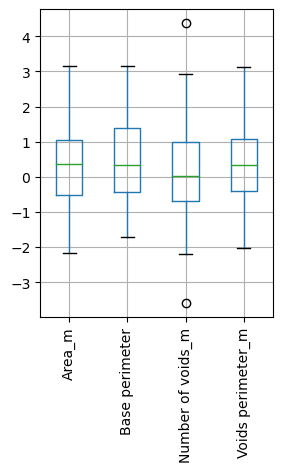

In [106]:
# boxplot of data distribution

full_model_std.boxplot(rot = 90, figsize=(3,4))
plt.show()

We will now apply the PCA transformation to the standardized data, using the principal components derived during the Phase 1 analysis.

In [107]:
# Compute the scores
scores = pca.transform(full_model_std)

# create a dataframe with the scores
scores_df = pd.DataFrame(scores, columns = ['z1', 'z2', 'z3','z4'])

#selected scores - we use the first 4 PCs
scores_sel_df = scores_df[['z1', 'z2', 'z3']]

scores_sel_df.head() 

,z1,z2,z3
0,0.259767,-0.509821,-0.232797
1,-0.011124,1.300669,-0.908916
2,-0.440354,-2.063735,-0.049553
3,-1.966409,-0.756384,-0.517824
4,-1.006189,2.827776,-0.159377


## Control Charts Application

#### Applying **z1 I-MR control chart**:

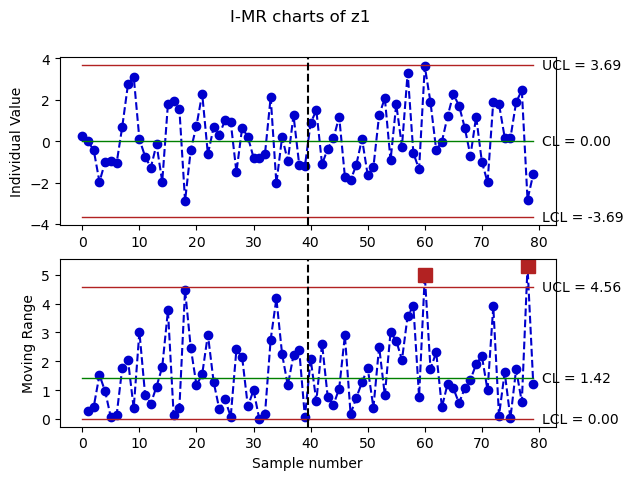

In [108]:
# Implementation of an IMR control chart on z1 component
data_IMR = qda.ControlCharts.IMR(scores_sel_df, 'z1',K=K_alpha,subset_size=len(new_df_model_std))

OOC Points detected by this control chart:

In [109]:
# Identify Out of Control (OOC) points in the I chart
OOC_idx_I_z1 = np.where(data_IMR['I_TEST1'].notnull())[0]
# Filter indices to include only those corresponding to Phase 2 data (greater than index 39)
OOC_idx_I_z1 = [idx for idx in OOC_idx_I_z1 if idx > 39]

# Identify Out of Control (OOC) points in the MR chart
OOC_idx_MR_z1 = np.where(data_IMR['MR_TEST1'].notnull())[0]
# Filter indices to include only those corresponding to Phase 2 data (greater than index 39)
OOC_idx_MR_z1 = [idx for idx in OOC_idx_MR_z1 if idx > 39]

# Retrieve and print the part names corresponding to the OOC indices
print("Faulty parts identified by I chart:")
print(full_df_model.iloc[OOC_idx_I_z1]['Part name'])

print("\nFaulty parts identified by MR chart:")
print(full_df_model.iloc[OOC_idx_MR_z1]['Part name'])

# Combine the identified parts into a single list without duplicates
found_z1 = list(
    set(
        full_df_model.iloc[OOC_idx_I_z1]['Part name'].tolist() +
        full_df_model.iloc[OOC_idx_MR_z1]['Part name'].tolist()
    )
)

Faulty parts identified by I chart:
Series([], Name: Part name, dtype: object)

Faulty parts identified by MR chart:
60      6_top_left
78    10_top_right
Name: Part name, dtype: object


#### Applying **z2 I-MR control chart**:

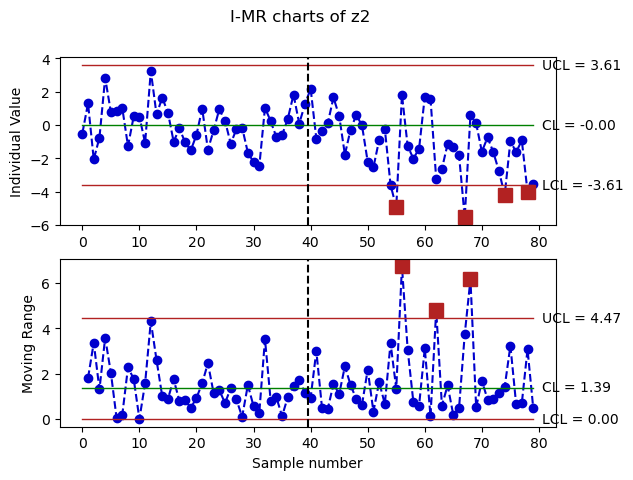

In [110]:
data_IMR = qda.ControlCharts.IMR(scores_sel_df, 'z2',K=K_alpha,subset_size=len(new_df_model_std))

OOC Points detected by this control chart:

In [111]:
# Identify Out of Control (OOC) points in the I chart
OOC_idx_I_z2 = np.where(data_IMR['I_TEST1'].notnull())[0]
# Filter indices to include only those corresponding to Phase 2 data (greater than index 39)
OOC_idx_I_z2 = [idx for idx in OOC_idx_I_z2 if idx > 39]

# Identify Out of Control (OOC) points in the MR chart
OOC_idx_MR_z2 = np.where(data_IMR['MR_TEST1'].notnull())[0]
# Filter indices to include only those corresponding to Phase 2 data (greater than index 39)
OOC_idx_MR_z2 = [idx for idx in OOC_idx_MR_z2 if idx > 39]

# Retrieve and print the part names corresponding to the OOC indices
print("Faulty parts identified by I chart:")
print(full_df_model.iloc[OOC_idx_I_z2]['Part name'])

print("\nFaulty parts identified by MR chart:")
print(full_df_model.iloc[OOC_idx_MR_z2]['Part name'])

# Combine the identified parts into a single list without duplicates
found_z2 = list(
    set(
        full_df_model.iloc[OOC_idx_I_z2]['Part name'].tolist() +
        full_df_model.iloc[OOC_idx_MR_z2]['Part name'].tolist()
    )
)

Faulty parts identified by I chart:
55    4_bottom_right
67    7_bottom_right
74       9_top_right
78      10_top_right
Name: Part name, dtype: object

Faulty parts identified by MR chart:
56     5_top_left
62    6_top_right
68     8_top_left
Name: Part name, dtype: object


#### Applying **z3 I-MR control chart**:

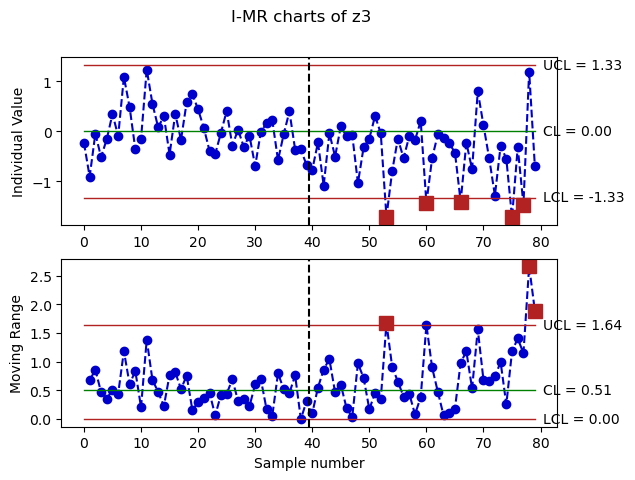

In [112]:
data_IMR = qda.ControlCharts.IMR(scores_sel_df, 'z3',K=K_alpha,subset_size=len(new_df_model_std))

OOC Points detected by this control chart:

In [113]:
# Identify Out of Control (OOC) points in the I chart
OOC_idx_I_z3 = np.where(data_IMR['I_TEST1'].notnull())[0]
# Filter indices to include only those corresponding to Phase 2 data (greater than index 39)
OOC_idx_I_z3 = [idx for idx in OOC_idx_I_z3 if idx > 39]

# Identify Out of Control (OOC) points in the MR chart
OOC_idx_MR_z3 = np.where(data_IMR['MR_TEST1'].notnull())[0]
# Filter indices to include only those corresponding to Phase 2 data (greater than index 39)
OOC_idx_MR_z3 = [idx for idx in OOC_idx_MR_z3 if idx > 39]

# Retrieve and print the part names corresponding to the OOC indices
print("Faulty parts identified by I chart:")
print(full_df_model.iloc[OOC_idx_I_z3]['Part name'])

print("\nFaulty parts identified by MR chart:")
print(full_df_model.iloc[OOC_idx_MR_z3]['Part name'])

# Combine the identified parts into a single list without duplicates
found_z3 = list(
    set(
        full_df_model.iloc[OOC_idx_I_z3]['Part name'].tolist() +
        full_df_model.iloc[OOC_idx_MR_z3]['Part name'].tolist()
    )
)

Faulty parts identified by I chart:
53     4_bottom_left
60        6_top_left
66       7_top_right
75    9_bottom_right
77    10_bottom_left
Name: Part name, dtype: object

Faulty parts identified by MR chart:
53      4_bottom_left
78       10_top_right
79    10_bottom_right
Name: Part name, dtype: object


#### Applying **Hotelling's T² Control Chart on PCA**:

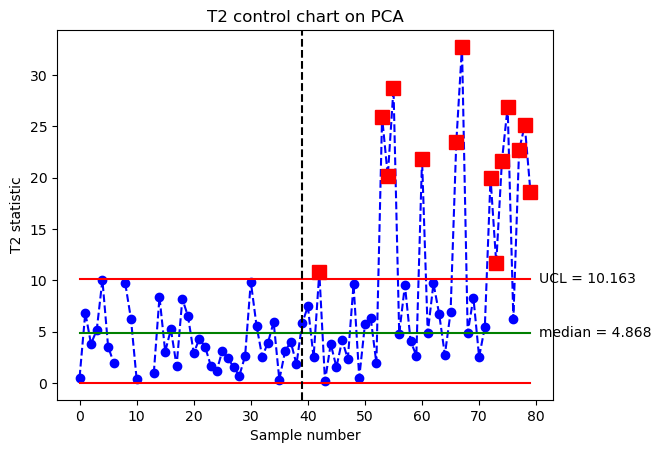

In [114]:
scores_sel_df_t2pca = scores_sel_df.copy()
scores_sel_df_t2pca.loc[del_from_pca_t2] = None


n = 1  # Sample size

alpha = alpha_f

# Calculate the Hotelling T² statistic
data_CC = pd.DataFrame()
data_CC['T2'] = [
    n * (scores_sel_df_t2pca.iloc[i] - Xbar_pca).transpose().dot(S2_inv_pca).dot(scores_sel_df_t2pca.iloc[i] - Xbar_pca)
    for i in range(len(scores_sel_df_t2pca))
]

# Add control limits and center line
data_CC['T2_UCL'] = UCL_pca  # Upper Control Limit
data_CC['T2_CL'] = data_CC['T2'].median()  # Center Line (median of T² statistics)
data_CC['T2_LCL'] = 0  # Lower Control Limit for T² charts is zero

# Identify Out-of-Control (OOC) points
data_CC['T2_TEST'] = np.where(data_CC['T2'] > data_CC['T2_UCL'], data_CC['T2'], np.nan)

# Step 4: Plot the T² control chart
plt.title('T2 control chart on PCA')
plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['T2_UCL'], color='r')
plt.plot(data_CC['T2_CL'], color='g')
plt.plot(data_CC['T2_LCL'], color='r')
plt.ylabel('T2 statistic')
plt.xlabel('Sample number')
plt.axvline(x=39, color='black', linestyle='--')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

OOC Points detected by this control chart:

In [115]:
# Identify Out of Control (OOC) points in the T2 chart
OOC_idx_T2_pca = np.where(data_CC['T2_TEST'].notnull())[0]
# Filter indices to include only those corresponding to Phase 2 data (greater than index 39)
OOC_idx_T2_pca = [idx for idx in OOC_idx_T2_pca if idx > 39]

# Retrieve and print the part names corresponding to the OOC indices
print("Faulty parts identified by T2 chart:")
print(full_df_model.iloc[OOC_idx_T2_pca]['Part name'])

# Combine the identified parts into a single list without duplicates
found_t2_pca = list(full_df_model.iloc[OOC_idx_T2_pca]['Part name'])

Faulty parts identified by T2 chart:
42        1_top_right
53      4_bottom_left
54        4_top_right
55     4_bottom_right
60         6_top_left
66        7_top_right
67     7_bottom_right
72         9_top_left
73      9_bottom_left
74        9_top_right
75     9_bottom_right
77     10_bottom_left
78       10_top_right
79    10_bottom_right
Name: Part name, dtype: object


#### Applying **Hotelling's T² Control Chart on Original Data**:

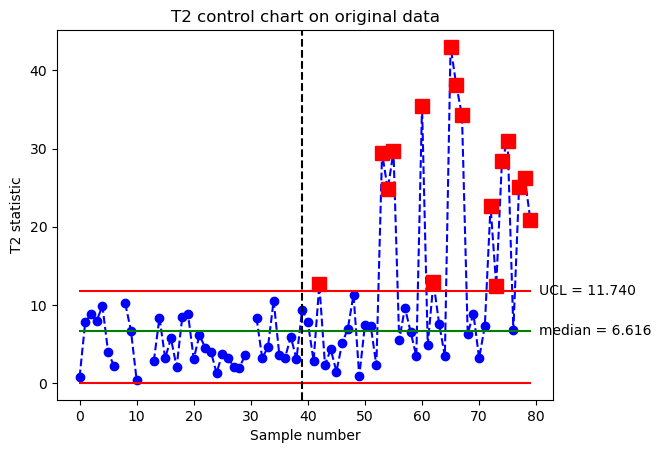

In [116]:
full_model_std_t2orig = full_model_std.copy()
full_model_std_t2orig.loc[del_from_orig_t2] = None

n = 1  # Sample size

alpha = alpha_f

# Calculate the Hotelling T² statistic
data_CC = pd.DataFrame()
data_CC['T2'] = [
    n * (full_model_std_t2orig.iloc[i] - Xbar_orig).transpose().dot(S2_inv_orig).dot(full_model_std_t2orig.iloc[i] - Xbar_orig)
    for i in range(len(full_model_std_t2orig))
]

# Add control limits and center line
data_CC['T2_UCL'] = UCL_orig  # Upper Control Limit
data_CC['T2_CL'] = data_CC['T2'].median()  # Center Line (median of T² statistics)
data_CC['T2_LCL'] = 0  # Lower Control Limit for T² charts is zero

# Identify Out-of-Control (OOC) points
data_CC['T2_TEST'] = np.where(data_CC['T2'] > data_CC['T2_UCL'], data_CC['T2'], np.nan)

# Plot the T2 control chart
plt.title('T2 control chart on original data')
plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['T2_UCL'], color='r')
plt.plot(data_CC['T2_CL'], color='g')
plt.plot(data_CC['T2_LCL'], color='r')
plt.ylabel('T2 statistic')
plt.xlabel('Sample number')
plt.axvline(x=39, color='black', linestyle='--')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

OOC Points detected by this control chart:

In [117]:
# Identify Out of Control (OOC) points in the T2 chart
OOC_idx_T2 = np.where(data_CC['T2_TEST'].notnull())[0]
# Filter indices to include only those corresponding to Phase 2 data (greater than index 39)
OOC_idx_T2 = [idx for idx in OOC_idx_T2 if idx > 39]

# Retrieve and print the part names corresponding to the OOC indices
print("Faulty parts identified by T2 chart:")
print(full_df_model.iloc[OOC_idx_T2]['Part name'])

# Combine the identified parts into a single list without duplicates
found_t2 = list(full_df_model.iloc[OOC_idx_T2]['Part name'])

Faulty parts identified by T2 chart:
42        1_top_right
53      4_bottom_left
54        4_top_right
55     4_bottom_right
60         6_top_left
62        6_top_right
65      7_bottom_left
66        7_top_right
67     7_bottom_right
72         9_top_left
73      9_bottom_left
74        9_top_right
75     9_bottom_right
77     10_bottom_left
78       10_top_right
79    10_bottom_right
Name: Part name, dtype: object


## SPC Performance Evaluation

We will evaluate the three statistical control methods introduced using the following metrics:
- **Confusion Matrix**: To evaluate the amount of true positives, true negatives, false positives, and false negatives.
- **Precision**: To measure the proportion of correctly identified faulty parts out of all parts identified as faulty.
- **Recall**: To assess the proportion of actual faulty parts that were correctly identified.
- **F1 Score**: To provide a balanced measure of precision and recall.

We will first create a function to compute these evaluation metrics for each control method.

In [118]:
# Alist with actual faults
actual_faults = [
    "1_top_right",
    "2_top_left",
    "4_bottom_left",
    "4_top_right",
    "6_top_left",
    "7_top_right",
    "7_bottom_left",
    "9_bottom_right",
    "10_top_right"
]
set_actual_faults = set(actual_faults)

full_list = list(new_df_phase2['Part name'])
set_full_list = set(full_list)

"""
    Calculate and display the confusion matrix for fault detection.

    Parameters:
    - found_t2_orig (list): List of predicted faulty parts.
    - printing (bool): Whether to print and display the confusion matrix and metrics.

    Returns:
    - Tuple: (TP, FP, FN, TN, precision, recall, f1_score)
"""

def confusion_matrix(found_t2_orig, printing=True):
    
    # Convert inputs to sets for easy operations
    set_found_faults = set(found_t2_orig)

    # Confusion Matrix Calculations
    TP = len(set_actual_faults & set_found_faults)  # True Positives: Correctly identified faults
    FP = len(set_found_faults - set_actual_faults)  # False Positives: Predicted faults that are not actual faults
    FN = len(set_actual_faults - set_found_faults)  # False Negatives: Missed actual faults
    TN = len(set_full_list - (set_actual_faults | set_found_faults))  # True Negatives: Correctly identified non-faults

    # Metrics Calculations
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Precision: TP / (TP + FP)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0     # Recall: TP / (TP + FN)
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # F1-Score

    if printing:
        # Print confusion matrix details
        print(
            " True Positives (TP):", TP,
            "\n False Positives (FP):", FP,
            "\n False Negatives (FN):", FN,
            "\n True Negatives (TN):", TN,
            "\n Precision:", round(precision, 3),
            "\n Recall:", round(recall, 3),
            "\n F1-Score:", round(f1_score, 3)
        )

        # Confusion matrix as a 2x2 matrix
        matrix = [[TP, FN], [FP, TN]]
        labels = ["Fault", "No Fault"]

        # Plot confusion matrix as a heatmap
        plt.figure(figsize=(4, 3))
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return TP, FP, FN, TN, precision, recall, f1_score


#### Individual PCA Charts Performance

 True Positives (TP): 5 
 False Positives (FP): 8 
 False Negatives (FN): 4 
 True Negatives (TN): 23 
 Precision: 0.385 
 Recall: 0.556 
 F1-Score: 0.455


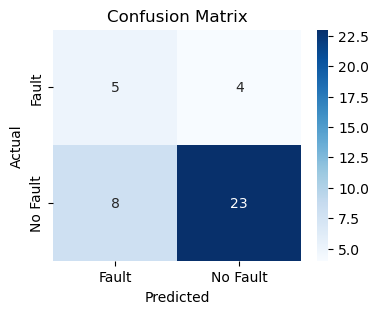

(5, 8, 4, 23, 0.38461538461538464, 0.5555555555555556, 0.4545454545454546)

In [119]:
# Combine the found faults from z1, z2, and z3, removing duplicates using a set
found_z = list(set(found_z1 + found_z2 + found_z3))

# Evaluate the individual charts results using the confusion matrix function
confusion_matrix(found_z)

- **Precision (0.385)**: The chart accurately identified 38.5% of the predicted faults as true faults.
- **Recall (0.556)**: The chart detected 55.6% of the actual faults, highlighting a moderate ability to catch faulty parts.
- **F1-Score (0.455)**: The balance between precision and recall is relatively low, suggesting that the chart struggles with accurately distinguishing faulty parts.

The confusion matrix reveals a tendency toward false positives, which could lead to unnecessary interventions. While recall is slightly better, the overall performance indicates that the model's utility is limited in its current form.

#### Multivarate T² Chart on PCA Performance

 True Positives (TP): 7 
 False Positives (FP): 7 
 False Negatives (FN): 2 
 True Negatives (TN): 24 
 Precision: 0.5 
 Recall: 0.778 
 F1-Score: 0.609


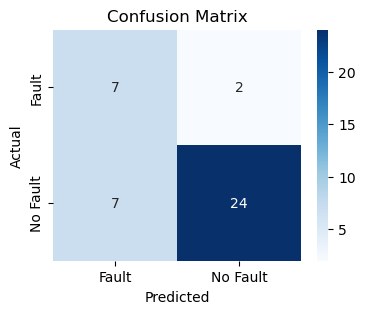

(7, 7, 2, 24, 0.5, 0.7777777777777778, 0.6086956521739131)

In [120]:
# Evaluate the T2 built on PCA result using the confusion matrix function
confusion_matrix(found_t2_pca)

- **Precision (0.5)**: The chart correctly identified 50% of the predicted faults as true faults, indicating an improvement in balancing false positives and true positives.
- **Recall (0.778)**: The chart successfully detected 77.8% of the actual faults, demonstrating strong sensitivity to identifying faulty parts.
- **F1-Score (0.609)**: The balance between precision and recall has improved compared to previous results, but there is still room for optimization.

The confusion matrix of this SPC method shows better recall and a more balanced detection of faults compared to false positives.

#### Multivarate T² Chart on Original Data Performance

 True Positives (TP): 8 
 False Positives (FP): 8 
 False Negatives (FN): 1 
 True Negatives (TN): 23 
 Precision: 0.5 
 Recall: 0.889 
 F1-Score: 0.64


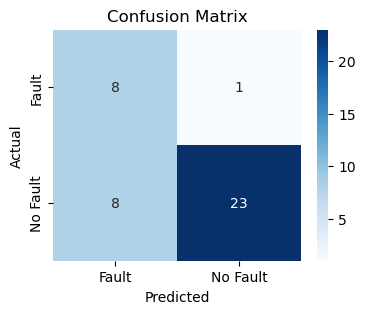

(8, 8, 1, 23, 0.5, 0.8888888888888888, 0.64)

In [121]:
# Evaluate the T2 built on original variables result using the confusion matrix function
confusion_matrix(found_t2)

- **Precision (0.5)**: The chart correctly identified 50% of the predicted faults as true faults, maintaining a moderate balance between false positives and true positives.
- **Recall (0.889)**: The chart detected 88.9% of the actual faults, showcasing strong sensitivity to faulty parts.
- **F1-Score (0.64)**: The overall balance between precision and recall has improved, indicating better fault detection capability compared to previous iterations.

The confusion matrix of this SPC method reflects a significant improvement in recall, with only one fault missed. However, the precision remains moderate due to the presence of false positives, which could lead to unnecessary interventions. Despite this, the model demonstrates high reliability in detecting faulty parts.

As we do not know the cost associated with false negatives and false positives, the most appropriate way to evaluate the methods is based on the **F1 score**. The **T² Chart on Original Data** achieves the highest F1 score among the examined methods. It reveals that the 4% variance not included in the PCA-based approach carries useful information.

Despite the high level of false positives, this method demonstrates the best balance between precision and recall, making it the most reliable choice for our application.

The F1 score achieved is not very high, which can be attributed to the limited number of in-control observations available for the design stage — only 40 observations. This small dataset restricts the ability to establish robust control limits and fully capture the process variability. With more in-control data, the performance of the control charts and their F1 score could improve significantly.

Incorporating data on characteristic defected parts could provide additional insights into the process and variability. This approach could enhance process understanding and allow to creat more percise SPC charts. It could provide a deeper understanding of how specific defects affect the monitored variables.


### **We choose the T² Chart on Original Data as the SPC method for our application.**

# Appendix 1 - Alpha selection
---

We will iterate over different values of **alpha**  and calculate the corresponding **recall**, **precision**, and **F1 score** for the **T² multivariate control chart on the original data**. This process will help us understand the effect of varying alpha on the chart's performance and determine the optimal value.

In [122]:
# Initialize a DataFrame to store results for each alpha
result_alpha = pd.DataFrame(columns=["Alpha", "Precision", "Recall", "F1 Score"])

# Define a range of alpha values to test
alpha_values = np.logspace(np.log10(0.001), np.log10(0.5), num=50)
#alpha_values = [0.01] #check the algorithm

# Iterate over each alpha value
for alpha_i in alpha_values:
    alpha = alpha_i

    del_from_orig_t2 = []
    OOC_idx_T2_orig_ph1 = [None]
    iteration = 0

    while len(OOC_idx_T2_orig_ph1) > 0:
        iteration += 1

        # Copy dataset and mask OOC points
        new_df_model_std_t2orig = new_df_model_std.copy()
        new_df_model_std_t2orig.loc[del_from_orig_t2] = None
        
        # Check that not too many points were deleted
        if len(new_df_model_std_t2orig[new_df_model_std_t2orig.isna().any(axis = 1)]) > 10:
        
            # save the latest model parameters
            Xbar3 = Xbar
            S2_inv3 = S2_inv
            UCL3 = UCL
            
            break

        # Constants
        n = 1  # Sample size
        m = len(new_df_model_std_t2orig)  # Number of samples
        p = 4  # Number of variables


        # Calculate the short-range estimator S2
        V = new_df_model_std_t2orig.diff().dropna()
        S2 = (1 / 2) * V.T.dot(V) / (m - 1)

        # Add regularization to avoid singular matrix
        S2 += np.eye(S2.shape[0]) * 1e-6

        # Invert the S2 matrix
        S2_inv = np.linalg.inv(S2)

        # Calculate the mean vector Xbar
        Xbar = new_df_model_std_t2orig.mean()

        # Calculate the Hotelling T² statistic
        data_CC = pd.DataFrame(columns=['T2'])
        deviations = new_df_model_std_t2orig - Xbar
        data_CC['T2'] = np.einsum('ij,ji->i', deviations.values @ S2_inv, deviations.values.T)

        # Add Upper Control Limit (UCL), Center Line (CL), and Lower Control Limit (LCL)
        UCL = ((m - 1) ** 2) / m * stats.beta.ppf(1 - alpha, p / 2, (m - p - 1) / 2)
        data_CC['T2_UCL'] = UCL
        data_CC['T2_CL'] = data_CC['T2'].median()
        data_CC['T2_LCL'] = 0  # Hotelling T² control chart has a zero lower limit

        # Flag samples exceeding the UCL
        data_CC['T2_TEST'] = np.where((data_CC['T2'] > data_CC['T2_UCL']), data_CC['T2'], np.nan)

        # Identify Out of Control (OOC) points in the T2 chart
        OOC_idx_T2_orig_ph1 = data_CC['T2_TEST'].dropna().index.tolist()

        if len(OOC_idx_T2_orig_ph1) > 0:
            # Update list of indices to mask in the next iteration
            del_from_orig_t2 += OOC_idx_T2_orig_ph1

        if len(OOC_idx_T2_orig_ph1) == 0:  # Save the final CC parameters
            Xbar3 = Xbar
            S2_inv3 = S2_inv
            UCL3 = UCL

    # Calculate Hotelling T² statistic for the full dataset
    data_CC=pd.DataFrame()
    data_CC['T2'] = np.nan
    for i in range(len(full_model_std)):
        data_CC.loc[i,'T2'] = n * (full_model_std.iloc[i] - Xbar3).transpose().dot(S2_inv3).dot(full_model_std.iloc[i] - Xbar3)

    # Add control limits to the full dataset
    data_CC['T2_UCL'] = UCL3
    data_CC['T2_LCL'] = 0
    data_CC['T2_TEST'] = np.where((data_CC['T2'] > data_CC['T2_UCL']), data_CC['T2'], np.nan)

    # Identify out-of-control points
    OOC_idx_T2 = data_CC['T2_TEST'].dropna().index.tolist()
    OOC_idx_T2 = [idx for idx in OOC_idx_T2 if idx > 39]  # Phase 2 data

    # Retrieve the predicted faulty parts
    found_t2_orig = list(full_df_model.iloc[OOC_idx_T2]['Part name'])

    # Evaluate performance using the confusion matrix
    TP, FP, FN, TN, precision, recall, f1_score = confusion_matrix(found_t2_orig, printing=False)
    
    # Append the results to the result DataFrame
    result_alpha = result_alpha.append({
        "Alpha": alpha,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score
    }, ignore_index=True)

In [123]:
result_alpha.head()

,Alpha,Precision,Recall,F1 Score
0,0.001000,0.538462,0.777778,0.636364
1,0.001135,0.538462,0.777778,0.636364
2,0.001289,0.538462,0.777778,0.636364
3,0.001463,0.538462,0.777778,0.636364
4,0.001661,0.538462,0.777778,0.636364


We will plot the **F1 score** against **alpha** on a logarithmic scale.

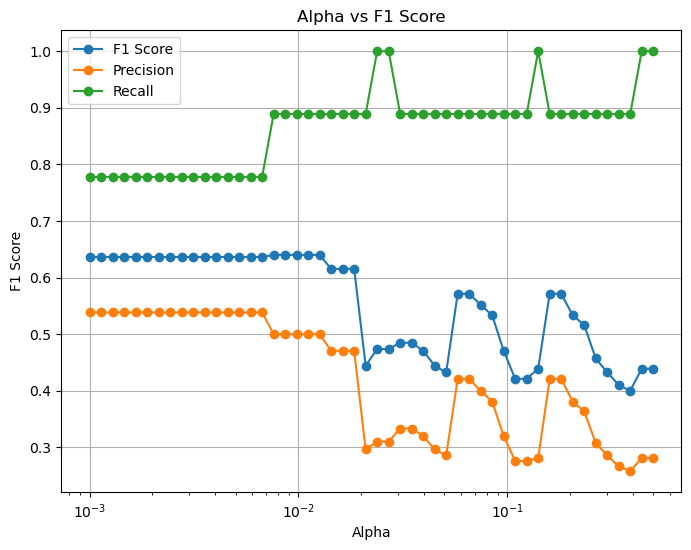

In [124]:
# Plot Alpha vs F1 Score
plt.figure(figsize=(8, 6))
plt.plot(result_alpha["Alpha"], result_alpha["F1 Score"], marker='o', linestyle='-', label="F1 Score")
plt.plot(result_alpha["Alpha"], result_alpha["Precision"], marker='o', linestyle='-', label="Precision")
plt.plot(result_alpha["Alpha"], result_alpha["Recall"], marker='o', linestyle='-', label="Recall")
plt.title("Alpha vs F1 Score")
plt.xlabel("Alpha")
plt.xscale('log')
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()

We observe the maximum F1 score around **alpha = 0.01**.

- **To the left** of this value:
  - Precision increases slightly, but recall decreases, resulting in a marginally lower F1 score.

- **To the right** of this value:
  - Precision decreases sharply. This causes the F1 score to drop noticeably.
  - Fluctuations in precision and F1 score are observed, likely caused by the stopping condition during the analysis.

Based on this analysis, **alpha = 0.01** achieves the best balance between precision and recall, minimizing false alarms while maintaining reliable fault detection.